In [1]:
#do not change the cell- used for authentication.

import pydata_google_auth
from google.cloud.bigquery import magics 

%load_ext google.cloud.bigquery

credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)
magics.context.credentials = credentials
magics.context.project = 'cpe695ws'

In [2]:
#import all the required libraries
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [3]:
# set seaborn and get the big query client to execute the queries.
sns.set()
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11,8)})
project_id = "cpe695ws"
client = bigquery.Client(project=project_id, credentials=credentials)

### Pre-processing of data. Extracting the data from relevant tables on the big query and creating a dataframe.

In [4]:
#get the age of the patients
age_query = """SELECT
    p.subject_id,p.gender,
    MIN( DATETIME_DIFF(admittime, dob, YEAR) )
        AS age
FROM `physionet-data.mimiciii_clinical.patients` p
INNER JOIN `physionet-data.mimiciii_clinical.admissions` a
  ON p.subject_id = a.subject_id
GROUP BY p.subject_id, p.dob, p.gender
ORDER BY p.subject_id"""

In [5]:
df_age = client.query(age_query).to_dataframe()
df_age

subject_id gender  age
0               2      M    0
1               3      M   76
2               4      F   48
3               5      M    0
4               6      F   66
...           ...    ...  ...
46515       99985      M   54
46516       99991      M   47
46517       99992      F   66
46518       99995      F   89
46519       99999      F   63

[46520 rows x 3 columns]

In [6]:
# group the patients based on the age range.
df_age['age_range'] = pd.cut(df_age.age, bins=[0, 11, 21, 31, 41,51,61,71,81,91,101,111,121,131,141,151,161,171,181,191,201,np.inf], labels=False, right=True) + 1

[Text(0, 0.5, 'Number of patients'), Text(0.5, 0, 'Age Range')]

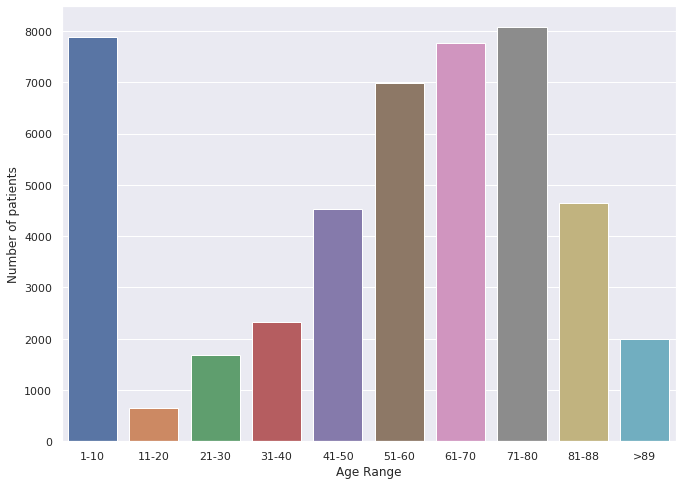

In [7]:
# plot number of patients vs age range.
df_age.age_range = df_age.age_range.fillna(value=1)
x_all_ages = df_age.age_range

ax = sns.countplot(x_all_ages, data=df_age)
ax.set_xticklabels(['1-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-88','>89'])
ax.set(xlabel='Age Range', ylabel='Number of patients')

[Text(0, 0.5, 'Number of patients'), Text(0.5, 0, 'Age Range')]

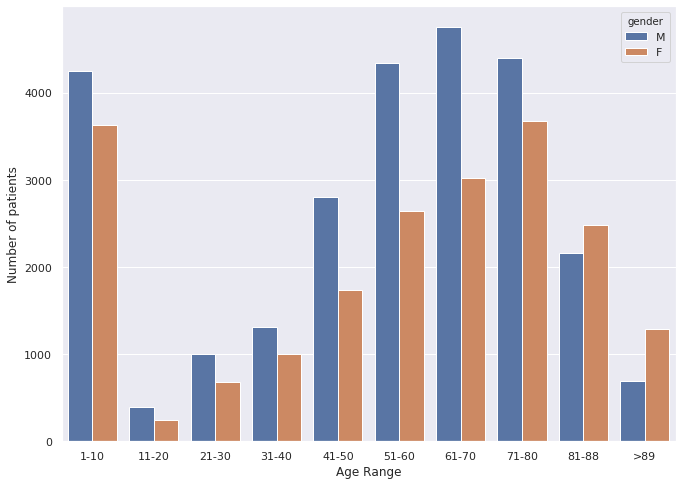

In [8]:
# plot showing number of patients vs age range based on gender.
ax = sns.countplot(x=df_age.age_range, hue=df_age.gender, data=df_age)
ax.set_xticklabels(['1-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-88','>89'])
ax.set(xlabel='Age Range', ylabel='Number of patients')

In [9]:
#Considering patients aged above 17 only.
df_age = df_age[df_age['age'] > 17]
df_age

subject_id gender  age  age_range
1               3      M   76        8.0
2               4      F   48        5.0
4               6      F   66        7.0
7               9      M   41        4.0
9              11      F   50        5.0
...           ...    ...  ...        ...
46515       99985      M   54        6.0
46516       99991      M   47        5.0
46517       99992      F   66        7.0
46518       99995      F   89        9.0
46519       99999      F   63        7.0

[38578 rows x 4 columns]

[Text(0, 0.5, 'Number of patients'), Text(0.5, 0, 'Age Range')]

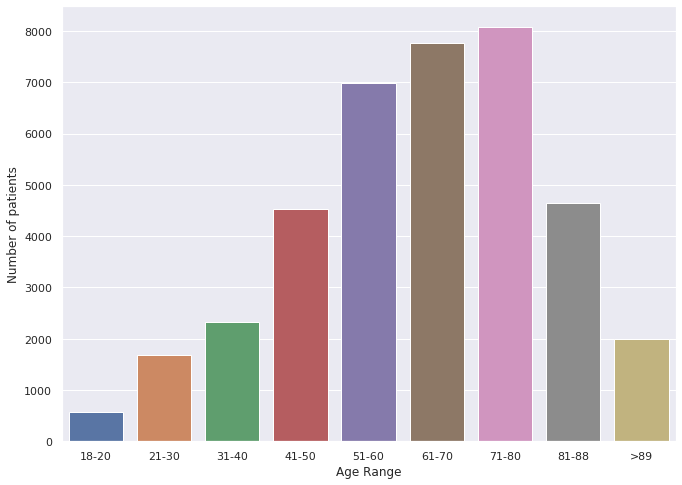

In [10]:
#plot for the filtered age range vs number of patients.
x_filtered_ages = df_age.age_range

ax = sns.countplot(x_filtered_ages, data=df_age)
ax.set_xticklabels(['18-20','21-30','31-40','41-50','51-60','61-70','71-80','81-88','>89'])
ax.set(xlabel='Age Range', ylabel='Number of patients')

[Text(0, 0.5, 'Number of patients'), Text(0.5, 0, 'Age Range')]

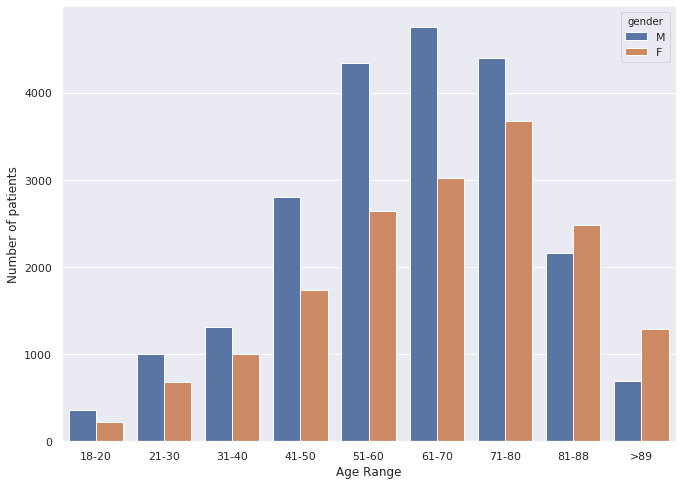

In [11]:
# plot for number of patients vs filtered age range based on gender.
ax = sns.countplot(x=df_age.age_range, hue=df_age.gender, data=df_age)
ax.set_xticklabels(['18-20','21-30','31-40','41-50','51-60','61-70','71-80','81-88','>89'])
ax.set(xlabel='Age Range', ylabel='Number of patients')

In [12]:
#query extraction admission related information for the patients.
stay_query = """SELECT a.subject_id, a.hadm_id, a.admission_type,
    DATETIME_DIFF(DISCHTIME,admittime, DAY) as hptl_stay
FROM `physionet-data.mimiciii_clinical.admissions` a
WHERE ADMISSION_TYPE IN ("ELECTIVE","URGENT","EMERGENCY")
ORDER BY a.subject_id, a.hadm_id;"""
df_stay = client.query(stay_query).to_dataframe()
df_stay

subject_id  hadm_id admission_type  hptl_stay
0               3   145834      EMERGENCY         11
1               4   185777      EMERGENCY          7
2               6   107064       ELECTIVE         16
3               9   150750      EMERGENCY          5
4              11   194540      EMERGENCY         25
...           ...      ...            ...        ...
51108       99985   176670      EMERGENCY         16
51109       99991   151118       ELECTIVE         12
51110       99992   197084      EMERGENCY          3
51111       99995   137810       ELECTIVE          3
51112       99999   113369       ELECTIVE          5

[51113 rows x 4 columns]

In [13]:
# # split the diagnosis string and fill empty string for na.
# df_stay['diagnosis'] = df_stay['diagnosis'].str.split(',')
# df_stay.diagnosis.fillna(value=' ', inplace=True)

In [14]:
#merge age with the hospital stay. This drops all admission values of patients below 18 years.
df_stay_age = df_stay.merge(df_age,left_on='subject_id', right_on='subject_id')
df_stay_age

subject_id  hadm_id admission_type  hptl_stay gender  age  age_range
0               3   145834      EMERGENCY         11      M   76        8.0
1               4   185777      EMERGENCY          7      F   48        5.0
2               6   107064       ELECTIVE         16      F   66        7.0
3               9   150750      EMERGENCY          5      M   41        4.0
4              11   194540      EMERGENCY         25      F   50        5.0
...           ...      ...            ...        ...    ...  ...        ...
50791       99985   176670      EMERGENCY         16      M   54        6.0
50792       99991   151118       ELECTIVE         12      M   47        5.0
50793       99992   197084      EMERGENCY          3      F   66        7.0
50794       99995   137810       ELECTIVE          3      F   89        9.0
50795       99999   113369       ELECTIVE          5      F   63        7.0

[50796 rows x 7 columns]

In [15]:
# calculate the mean stay of each patient.
df_stay_age_range = df_stay_age
df_stay_age_range['mean_stay'] = df_stay_age.groupby('age_range')['hptl_stay'].transform('mean')
df_stay_age_range

subject_id  hadm_id admission_type  hptl_stay gender  age  age_range  \
0               3   145834      EMERGENCY         11      M   76        8.0   
1               4   185777      EMERGENCY          7      F   48        5.0   
2               6   107064       ELECTIVE         16      F   66        7.0   
3               9   150750      EMERGENCY          5      M   41        4.0   
4              11   194540      EMERGENCY         25      F   50        5.0   
...           ...      ...            ...        ...    ...  ...        ...   
50791       99985   176670      EMERGENCY         16      M   54        6.0   
50792       99991   151118       ELECTIVE         12      M   47        5.0   
50793       99992   197084      EMERGENCY          3      F   66        7.0   
50794       99995   137810       ELECTIVE          3      F   89        9.0   
50795       99999   113369       ELECTIVE          5      F   63        7.0   

       mean_stay  
0       9.905150  
1      10.156441  
2      10.422608  
3       9.965583  
4      10.156441  
...          ...  
50791  10.265627  
50792  10.156441  
50793  10.422608  
50794   9.378682  
50795  10.422608  

[50796 rows x 8 columns]

[Text(0, 0.5, 'Mean LoS'), Text(0.5, 0, 'Age Range')]

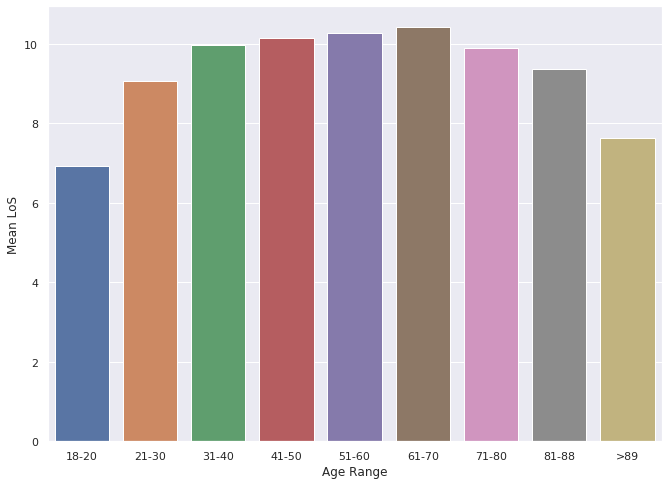

In [16]:
# plot showing mean los vs age range.
ax = sns.barplot(x=df_stay_age_range.age_range, y=df_stay_age_range.mean_stay, data=df_stay_age_range)
ax.set_xticklabels(['18-20','21-30','31-40','41-50','51-60','61-70','71-80','81-88','>89'])
ax.set(xlabel='Age Range', ylabel='Mean LoS')

In [17]:
# merge the stay information with the gender and age information.
df_stay_age_gender = df_stay_age
df_stay_age_gender['mean_stay'] = df_stay_age.groupby(['age_range','gender'])['hptl_stay'].transform('mean')
df_stay_age_gender

subject_id  hadm_id admission_type  hptl_stay gender  age  age_range  \
0               3   145834      EMERGENCY         11      M   76        8.0   
1               4   185777      EMERGENCY          7      F   48        5.0   
2               6   107064       ELECTIVE         16      F   66        7.0   
3               9   150750      EMERGENCY          5      M   41        4.0   
4              11   194540      EMERGENCY         25      F   50        5.0   
...           ...      ...            ...        ...    ...  ...        ...   
50791       99985   176670      EMERGENCY         16      M   54        6.0   
50792       99991   151118       ELECTIVE         12      M   47        5.0   
50793       99992   197084      EMERGENCY          3      F   66        7.0   
50794       99995   137810       ELECTIVE          3      F   89        9.0   
50795       99999   113369       ELECTIVE          5      F   63        7.0   

       mean_stay  
0      10.070670  
1      10.084559  
2      10.716571  
3       9.628913  
4      10.084559  
...          ...  
50791  10.156342  
50792  10.203017  
50793  10.716571  
50794   8.951552  
50795  10.716571  

[50796 rows x 8 columns]

In [18]:
# get unique counts of different admission type
df_adm_unique = df_stay_age_gender.drop_duplicates(['subject_id','hadm_id'])
df_adm_unique.admission_type.value_counts()

EMERGENCY    41784
ELECTIVE      7700
URGENT        1312
Name: admission_type, dtype: int64

[Text(0, 0.5, 'Mean LoS'), Text(0.5, 0, 'Age Range')]

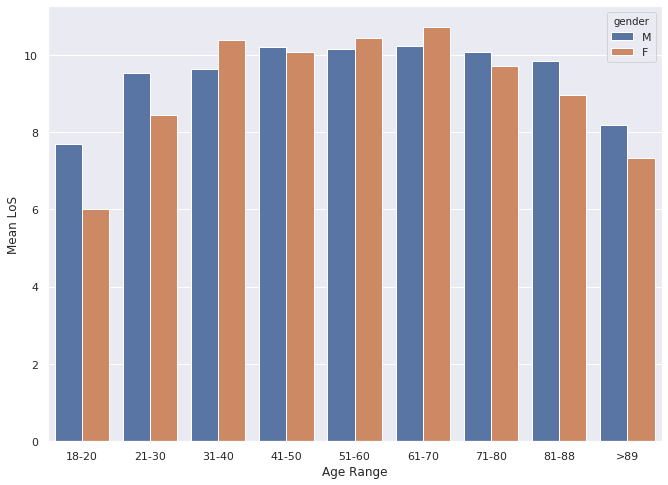

In [19]:
# plot showing mean los vs age range based on gender.
ax = sns.barplot(x=df_stay_age_gender.age_range, y=df_stay_age_gender.mean_stay, hue=df_stay_age_gender.gender,data=df_stay_age_gender)
ax.set_xticklabels(['18-20','21-30','31-40','41-50','51-60','61-70','71-80','81-88','>89'])
ax.set(xlabel='Age Range', ylabel='Mean LoS')

[Text(0, 0.5, 'Number of patients'), Text(0.5, 0, 'Admission Type')]

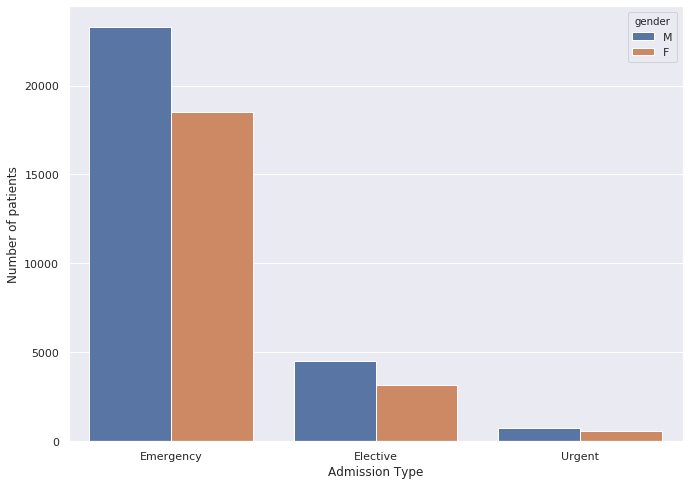

In [20]:
# plot of admission type vs number of patients based on gender.
ax = sns.countplot(x=df_adm_unique.admission_type, hue=df_adm_unique.gender, data=df_adm_unique)
ax.set_xticklabels(['Emergency','Elective','Urgent'])
ax.set(xlabel='Admission Type', ylabel='Number of patients')

[Text(0, 0.5, 'Number of patients'), Text(0.5, 0, 'Age Range')]

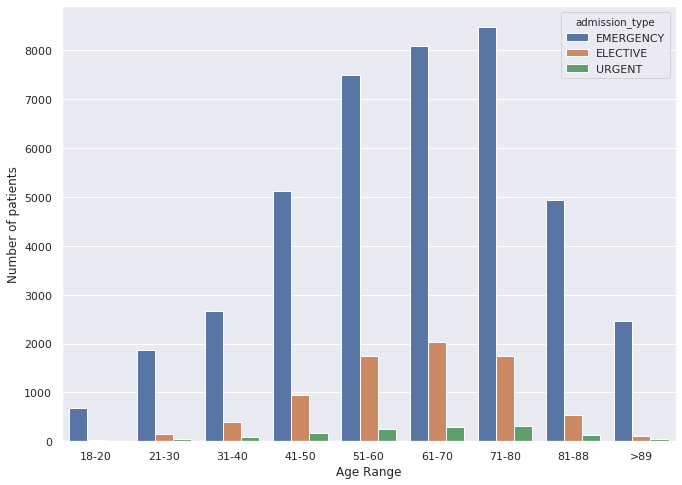

In [21]:
# plot for age range vs number of patients based on admission type.
ax = sns.countplot(x=df_adm_unique.age_range, hue=df_adm_unique.admission_type, data=df_adm_unique)
ax.set_xticklabels(['18-20','21-30','31-40','41-50','51-60','61-70','71-80','81-88','>89'])
ax.set(xlabel='Age Range', ylabel='Number of patients')

In [22]:
# get the height and weight of the patients.
query = """SELECT ics.subject_id, max(ht.height) as height, max(wt.weight) weight  
FROM `physionet-data.mimiciii_derived.heightfirstday` ht INNER JOIN
`physionet-data.mimiciii_derived.weightfirstday` wt ON ht.icustay_id = wt.icustay_id inner join
`physionet-data.mimiciii_clinical.icustays` ics ON ht.icustay_id = ics.icustay_id group by ics.subject_id"""

df_ht_wt = client.query(query).to_dataframe()
df_ht_wt

subject_id      height weight
0           10950  168.002857   99.2
1           29904  161.290000   87.2
2           93535  147.320000  106.3
3           74032  161.290000     70
4           19167  193.040000  140.4
...           ...         ...    ...
38601       30588  170.180000   79.5
38602        1109  170.180000  73.03
38603       23693  170.180000   77.5
38604       77795  170.180000   59.9
38605       22068  170.180000     75

[38606 rows x 3 columns]

In [23]:
# merge the height and weight to form a unified dataframe.
df = df_stay_age_gender.merge(df_ht_wt,left_on=['subject_id'], right_on=['subject_id'], how= "left")
df

subject_id  hadm_id admission_type  hptl_stay gender  age  age_range  \
0               3   145834      EMERGENCY         11      M   76        8.0   
1               4   185777      EMERGENCY          7      F   48        5.0   
2               6   107064       ELECTIVE         16      F   66        7.0   
3               9   150750      EMERGENCY          5      M   41        4.0   
4              11   194540      EMERGENCY         25      F   50        5.0   
...           ...      ...            ...        ...    ...  ...        ...   
50791       99985   176670      EMERGENCY         16      M   54        6.0   
50792       99991   151118       ELECTIVE         12      M   47        5.0   
50793       99992   197084      EMERGENCY          3      F   66        7.0   
50794       99995   137810       ELECTIVE          3      F   89        9.0   
50795       99999   113369       ELECTIVE          5      F   63        7.0   

       mean_stay  height weight  
0      10.070670  179.07   96.8  
1      10.084559     NaN   53.6  
2      10.716571     NaN   None  
3       9.628913  182.88    104  
4      10.084559     NaN   None  
...          ...     ...    ...  
50791  10.156342     NaN   None  
50792  10.203017     NaN  100.5  
50793  10.716571     NaN   65.4  
50794   8.951552  159.00     68  
50795  10.716571  152.00   96.5  

[50796 rows x 10 columns]

In [24]:
# query the blood gas levels on the day of admission.
query = """SELECT bg.subject_id, bg.hadm_id, max(bg.so2) as so2, max(bg.spo2) as spo2, max(bg.po2) as po2, max(bg.pco2) as pco2, max(bg.fio2_chartevents) as fio2_chartevents, max(bg.fio2) as fio2, max(bg.aado2) as aado2, max(bg.pao2fio2) as pao2fio2, max(bg.ph) as ph, max(bg.baseexcess) as baseexcess, max(bg.bicarbonate) as bicarbonate, max(bg.totalco2) as totalco2, max(bg.hematocrit) as hematocrit, max(bg.hemoglobin) as hemoglobin, max(bg.carboxyhemoglobin) as carboxyhemoglobin, max(bg.methemoglobin) as methemoglobin, max(bg.chloride) as chloride, max(bg.calcium) as calcium, max(bg.temperature) as temperature, max(bg.potassium) as potassium, max(bg.sodium) as sodium, max(bg.lactate) as lactate, max(bg.glucose) as glucose, max(bg.intubated) as intubated, max(bg.tidalvolume) as tidalvolume, max(bg.ventilationrate) as ventilationrate, max(bg.ventilator) as ventilator, max(bg.peep) as peep, max(bg.o2flow) as o2flow, max(bg.requiredo2) as requiredo2
FROM `physionet-data.mimiciii_derived.bloodgasfirstdayarterial` bg group by bg.subject_id, bg.hadm_id"""

df_blood_gas = client.query(query).to_dataframe()
df_blood_gas

subject_id  hadm_id   so2   spo2    po2  pco2  fio2_chartevents   fio2  \
0           55973   152234  96.0  100.0  114.0  49.0               NaN    NaN   
1           27513   163557  98.0   98.0  163.0  45.0         50.000000    NaN   
2           29904   129607  98.0  100.0  496.0  49.0         40.000001    NaN   
3           93535   121562   NaN  100.0   98.0  84.0         30.000000    NaN   
4            9514   127229  98.0  100.0  183.0  38.0         40.000001   40.0   
...           ...      ...   ...    ...    ...   ...               ...    ...   
32712       11776   161707  98.0  100.0  289.0  63.0         80.000001  100.0   
32713       13083   186679   NaN  100.0  435.0  47.0         50.000000   40.0   
32714       13620   169431   NaN   95.0   70.0  54.0               NaN    NaN   
32715       28775   134959   NaN   99.0  170.0  50.0         40.000001  100.0   
32716        7630   129161  98.0  100.0  439.0  47.0         60.000002    NaN   

       aado2    pao2fio2  ...  sodium  lactate  glucose  intubated  \
0        NaN         NaN  ...     NaN      1.4      NaN       None   
1        NaN  216.000000  ...     NaN      5.1      NaN       None   
2        NaN  797.499988  ...   141.0      2.7    137.0       None   
3        NaN  266.666667  ...     NaN      1.1      NaN       None   
4        NaN  457.499993  ...     NaN      0.9    105.0       None   
...      ...         ...  ...     ...      ...      ...        ...   
32712  534.0  301.666655  ...   145.0      4.9    222.0       None   
32713    NaN  482.500000  ...   148.0      9.4    167.0       None   
32714    NaN         NaN  ...     NaN      1.0      NaN       None   
32715  533.0  424.999994  ...     NaN      NaN      NaN       None   
32716    NaN  258.000000  ...   138.0      NaN    163.0       None   

       tidalvolume  ventilationrate  ventilator  peep  o2flow  requiredo2  
0              NaN             None        None   NaN     NaN         NaN  
1              NaN             None        None   NaN     NaN         NaN  
2              NaN             None        None   NaN     NaN         NaN  
3              NaN             None        None   NaN     NaN         NaN  
4            740.0             None        None   5.0     NaN         NaN  
...            ...              ...         ...   ...     ...         ...  
32712        780.0             None        None   NaN     NaN        88.0  
32713        700.0             None        None   5.0     NaN         NaN  
32714          NaN             None        None   NaN     NaN         NaN  
32715        550.0             None        None   NaN     NaN        87.0  
32716          NaN             None        None   NaN     NaN         NaN  

[32717 rows x 32 columns]

In [25]:
# merge the blood gas level with the dataframe
df = df.merge(df_blood_gas,left_on=['subject_id','hadm_id'], right_on=['subject_id','hadm_id'], how= "left")
df

subject_id  hadm_id admission_type  hptl_stay gender  age  age_range  \
0               3   145834      EMERGENCY         11      M   76        8.0   
1               4   185777      EMERGENCY          7      F   48        5.0   
2               6   107064       ELECTIVE         16      F   66        7.0   
3               9   150750      EMERGENCY          5      M   41        4.0   
4              11   194540      EMERGENCY         25      F   50        5.0   
...           ...      ...            ...        ...    ...  ...        ...   
50791       99985   176670      EMERGENCY         16      M   54        6.0   
50792       99991   151118       ELECTIVE         12      M   47        5.0   
50793       99992   197084      EMERGENCY          3      F   66        7.0   
50794       99995   137810       ELECTIVE          3      F   89        9.0   
50795       99999   113369       ELECTIVE          5      F   63        7.0   

       mean_stay  height weight  ...  sodium  lactate  glucose  intubated  \
0      10.070670  179.07   96.8  ...   153.0      8.8    299.0       None   
1      10.084559     NaN   53.6  ...     NaN      2.1      NaN       None   
2      10.716571     NaN   None  ...     NaN      NaN      NaN       None   
3       9.628913  182.88    104  ...   138.0      2.7    178.0       None   
4      10.084559     NaN   None  ...     NaN      NaN      NaN       None   
...          ...     ...    ...  ...     ...      ...      ...        ...   
50791  10.156342     NaN   None  ...     NaN      2.1      NaN       None   
50792  10.203017     NaN  100.5  ...     NaN      1.0      NaN       None   
50793  10.716571     NaN   65.4  ...     NaN      NaN      NaN       None   
50794   8.951552  159.00     68  ...   135.0      1.5    128.0       None   
50795  10.716571  152.00   96.5  ...     NaN      NaN      NaN       None   

       tidalvolume  ventilationrate  ventilator  peep  o2flow  requiredo2  
0            800.0             None        None   8.0     NaN        70.0  
1              NaN             None        None   NaN     6.0         NaN  
2              NaN             None        None   NaN     NaN         NaN  
3            600.0             None        None   8.0     NaN         NaN  
4              NaN             None        None   NaN     NaN         NaN  
...            ...              ...         ...   ...     ...         ...  
50791        500.0             None        None   8.0     NaN        87.0  
50792          NaN             None        None   NaN     4.0        83.0  
50793          NaN             None        None   NaN     NaN         NaN  
50794        620.0             None        None   NaN     NaN         NaN  
50795          NaN             None        None   NaN     NaN         NaN  

[50796 rows x 40 columns]

In [26]:
# query the gcs on first day of admission.
query = """SELECT gcs.subject_id, gcs.hadm_id, max(gcs.gcsmotor) as gcsmotor, max(gcs.gcsverbal) as gcsverbal, max(gcs.gcseyes) as gcseyes, max(gcs.endotrachflag) as  endotrachflag
FROM `physionet-data.mimiciii_derived.gcsfirstday` gcs group by gcs.subject_id, gcs.hadm_id"""
df_gcs = client.query(query).to_dataframe()
df_gcs

subject_id  hadm_id  gcsmotor  gcsverbal  gcseyes  endotrachflag
0           15909   135069       NaN        NaN      NaN            NaN
1           20948   109512       NaN        NaN      NaN            NaN
2           17020   158088       NaN        NaN      NaN            NaN
3            4638   145058       NaN        NaN      NaN            NaN
4           21695   150812       NaN        NaN      NaN            NaN
...           ...      ...       ...        ...      ...            ...
57781         103   133550       2.0        1.0      1.0            0.0
57782       47967   175890       5.0        1.0      2.0            0.0
57783       58128   108958       5.0        1.0      2.0            0.0
57784       24244   165022       1.0        1.0      1.0            0.0
57785        6018   173478       3.0        1.0      1.0            0.0

[57786 rows x 6 columns]

In [27]:
# merge the gcs information with the dataframe
df = df.merge(df_gcs,left_on=['subject_id','hadm_id'], right_on=['subject_id','hadm_id'], how= "left")
df

subject_id  hadm_id admission_type  hptl_stay gender  age  age_range  \
0               3   145834      EMERGENCY         11      M   76        8.0   
1               4   185777      EMERGENCY          7      F   48        5.0   
2               6   107064       ELECTIVE         16      F   66        7.0   
3               9   150750      EMERGENCY          5      M   41        4.0   
4              11   194540      EMERGENCY         25      F   50        5.0   
...           ...      ...            ...        ...    ...  ...        ...   
50791       99985   176670      EMERGENCY         16      M   54        6.0   
50792       99991   151118       ELECTIVE         12      M   47        5.0   
50793       99992   197084      EMERGENCY          3      F   66        7.0   
50794       99995   137810       ELECTIVE          3      F   89        9.0   
50795       99999   113369       ELECTIVE          5      F   63        7.0   

       mean_stay  height weight  ...  tidalvolume  ventilationrate  \
0      10.070670  179.07   96.8  ...        800.0             None   
1      10.084559     NaN   53.6  ...          NaN             None   
2      10.716571     NaN   None  ...          NaN             None   
3       9.628913  182.88    104  ...        600.0             None   
4      10.084559     NaN   None  ...          NaN             None   
...          ...     ...    ...  ...          ...              ...   
50791  10.156342     NaN   None  ...        500.0             None   
50792  10.203017     NaN  100.5  ...          NaN             None   
50793  10.716571     NaN   65.4  ...          NaN             None   
50794   8.951552  159.00     68  ...        620.0             None   
50795  10.716571  152.00   96.5  ...          NaN             None   

       ventilator  peep  o2flow  requiredo2  gcsmotor  gcsverbal  gcseyes  \
0            None   8.0     NaN        70.0       1.0        0.0      1.0   
1            None   NaN     6.0         NaN       6.0        5.0      4.0   
2            None   NaN     NaN         NaN       6.0        5.0      4.0   
3            None   8.0     NaN         NaN       5.0        0.0      1.0   
4            None   NaN     NaN         NaN       5.0        4.0      4.0   
...           ...   ...     ...         ...       ...        ...      ...   
50791        None   8.0     NaN        87.0       6.0        5.0      4.0   
50792        None   NaN     4.0        83.0       6.0        5.0      3.0   
50793        None   NaN     NaN         NaN       6.0        5.0      4.0   
50794        None   NaN     NaN         NaN       6.0        0.0      3.0   
50795        None   NaN     NaN         NaN       6.0        5.0      4.0   

       endotrachflag  
0                1.0  
1                0.0  
2                0.0  
3                1.0  
4                0.0  
...              ...  
50791            0.0  
50792            0.0  
50793            0.0  
50794            1.0  
50795            0.0  

[50796 rows x 44 columns]

In [28]:
# query the lab reports on first day of admission.
query = """SELECT lab.subject_id, lab.hadm_id, max(lab.aniongap_min) as aniongap_min, max(lab.aniongap_max) as aniongap_max, max(lab.albumin_min) as albumin_min, max(lab.albumin_max) as albumin_max, max(lab.bands_min) as bands_min, max(lab.bands_max) as bands_max, max(lab.bicarbonate_min) as bicarbonate_min, max(lab.bicarbonate_max) as bicarbonate_max,	max(lab.bilirubin_min) as bilirubin_min, max(lab.bilirubin_max) as bilirubin_max, max(lab.creatinine_min) as creatinine_min, max(lab.creatinine_max) as creatinine_max, max(lab.chloride_min) as chloride_min, max(lab.chloride_max) as chloride_max,max(lab.glucose_min) as glucose_min, max(lab.glucose_max) as glucose_max, max(lab.hematocrit_min) as hematocrit_min, max(lab.hematocrit_max) as hematocrit_max, max(lab.hemoglobin_min) as hemoglobin_min, max(lab.hemoglobin_max) as hemoglobin_max, max(lab.lactate_min) as lactate_min, max(lab.lactate_max) as lactate_max,max(lab.platelet_min) as platelet_min, max(lab.platelet_max)  as platelet_max, max(lab.potassium_min) as potassium_min, max(lab.potassium_max) as potassium_max, max(lab.ptt_min) as ptt_min, max(lab.ptt_max) as ptt_max, max(lab.inr_min) as inr_min, max(lab.inr_max) as inr_max, max(lab.pt_min) as pt_min, max(lab.pt_max) as pt_max, max(lab.sodium_min) as sodium_min, max(lab.sodium_max) as sodium_max, max(lab.bun_min) as bun_min,max(lab.bun_max) as bun_max, max(lab.wbc_min) as wbc_min, max(lab.wbc_max) as wbc_max
FROM `physionet-data.mimiciii_derived.labsfirstday` lab group by lab.subject_id, lab.hadm_id"""

df_lab = client.query(query).to_dataframe()
df_lab

subject_id  hadm_id  aniongap_min  aniongap_max  albumin_min  \
0              21   109451          23.0          27.0          NaN   
1              21   111970          15.0          19.0          2.1   
2              34   144319          11.0          12.0          NaN   
3              36   122659          13.0          16.0          1.7   
4              49   190539          13.0          13.0          NaN   
...           ...      ...           ...           ...          ...   
57781       98336   186728          10.0          18.0          4.0   
57782       98605   178826           6.0          11.0          2.4   
57783       98748   122488           9.0           9.0          NaN   
57784       99913   175989          11.0          12.0          NaN   
57785       99995   137810           8.0           9.0          NaN   

       albumin_max  bands_min  bands_max  bicarbonate_min  bicarbonate_max  \
0              NaN        NaN        NaN             15.0             19.0   
1              2.1        1.0        1.0             23.0             24.0   
2              NaN        NaN        NaN             26.0             28.0   
3              1.7        NaN        NaN             21.0             26.0   
4              NaN        NaN        NaN             27.0             27.0   
...            ...        ...        ...              ...              ...   
57781          4.0        NaN        NaN             25.0             29.0   
57782          2.7        2.0        2.0             20.0             24.0   
57783          NaN        NaN        NaN             23.0             24.0   
57784          NaN        NaN        NaN             20.0             21.0   
57785          NaN        NaN        NaN             32.0             34.0   

       ...  inr_min  inr_max  pt_min  pt_max  sodium_min  sodium_max  bun_min  \
0      ...      1.9      4.0    16.4    23.5       137.0       140.0     94.0   
1      ...      1.7      1.8    18.1    19.1       137.0       140.0     49.0   
2      ...      2.6      3.3    26.9    32.6       139.0       143.0     30.0   
3      ...      1.5      1.5    16.0    16.1       129.0       135.0     28.0   
4      ...      2.1      2.1    17.4    17.4       136.0       140.0     18.0   
...    ...      ...      ...     ...     ...         ...         ...      ...   
57781  ...      1.4      1.4    15.4    15.8       127.0       134.0     18.0   
57782  ...      1.4      1.8    15.4    18.6       137.0       138.0      6.0   
57783  ...      1.4      1.5    15.4    16.6       134.0       139.0     16.0   
57784  ...      1.4      2.0    15.4    21.2       133.0       139.0      9.0   
57785  ...      1.4      1.9    15.4    19.7       132.0       139.0     10.0   

       bun_max  wbc_min  wbc_max  
0        102.0     21.1     23.5  
1         50.0     30.5     41.2  
2         38.0      7.1      7.9  
3         30.0     20.1     21.9  
4         18.0     10.3     10.7  
...        ...      ...      ...  
57781     25.0     10.4     12.2  
57782      6.0      3.6      5.1  
57783     23.0      8.4     13.4  
57784     12.0      7.8     10.2  
57785     13.0      7.3      8.2  

[57786 rows x 40 columns]

In [29]:
# merge the lab reports with the dataframe
df = df.merge(df_lab,left_on=['subject_id','hadm_id'], right_on=['subject_id','hadm_id'], how= "left")
df

subject_id  hadm_id admission_type  hptl_stay gender  age  age_range  \
0               3   145834      EMERGENCY         11      M   76        8.0   
1               4   185777      EMERGENCY          7      F   48        5.0   
2               6   107064       ELECTIVE         16      F   66        7.0   
3               9   150750      EMERGENCY          5      M   41        4.0   
4              11   194540      EMERGENCY         25      F   50        5.0   
...           ...      ...            ...        ...    ...  ...        ...   
50791       99985   176670      EMERGENCY         16      M   54        6.0   
50792       99991   151118       ELECTIVE         12      M   47        5.0   
50793       99992   197084      EMERGENCY          3      F   66        7.0   
50794       99995   137810       ELECTIVE          3      F   89        9.0   
50795       99999   113369       ELECTIVE          5      F   63        7.0   

       mean_stay  height weight  ...  inr_min  inr_max  pt_min  pt_max  \
0      10.070670  179.07   96.8  ...      1.3      1.7    13.5    15.7   
1      10.084559     NaN   53.6  ...      1.1      1.1    12.8    12.8   
2      10.716571     NaN   None  ...      1.0      1.4    12.6    14.6   
3       9.628913  182.88    104  ...      1.1      1.1    12.7    12.7   
4      10.084559     NaN   None  ...      NaN      NaN     NaN     NaN   
...          ...     ...    ...  ...      ...      ...     ...     ...   
50791  10.156342     NaN   None  ...      1.1      1.1    12.5    12.5   
50792  10.203017     NaN  100.5  ...      1.0      1.0    12.1    12.1   
50793  10.716571     NaN   65.4  ...      1.1      1.1    12.9    12.9   
50794   8.951552  159.00     68  ...      1.4      1.9    15.4    19.7   
50795  10.716571  152.00   96.5  ...      NaN      NaN     NaN     NaN   

       sodium_min  sodium_max  bun_min  bun_max  wbc_min  wbc_max  
0           136.0       153.0     41.0     53.0     11.3     24.4  
1           141.0       141.0     10.0     10.0      9.7      9.7  
2           134.0       138.0     62.0     65.0     10.6     10.6  
3           136.0       140.0     16.0     17.0      7.5     13.7  
4           141.0       142.0     14.0     19.0      9.3     12.8  
...           ...         ...      ...      ...      ...      ...  
50791       134.0       136.0     13.0     16.0     12.3     12.6  
50792       143.0       146.0     18.0     26.0      4.2      7.3  
50793       136.0       136.0     56.0     56.0     17.1     21.4  
50794       132.0       139.0     10.0     13.0      7.3      8.2  
50795       138.0       141.0     15.0     32.0      9.3     12.4  

[50796 rows x 82 columns]

In [30]:
# query the vitals on first day of admission.
query = """SELECT vitals.subject_id, vitals.hadm_id, max(vitals.heartrate_mean) as heartrate, max(vitals.sysbp_mean) as sysbp, max(vitals.diasbp_mean) as diasbp, max(vitals.meanbp_mean) as meanbp, max(vitals.resprate_mean) as resprate, max(vitals.tempc_mean) as tempc, max(vitals.spo2_mean) as spo2, max(vitals.glucose_mean) as glucose
FROM `physionet-data.mimiciii_derived.vitalsfirstday` vitals group by vitals.subject_id, vitals.hadm_id"""
df_vitals = client.query(query).to_dataframe()
df_vitals

subject_id  hadm_id   heartrate       sysbp     diasbp     meanbp  \
0               3   145834  111.785714  102.960000  55.720000  75.692812   
1               4   185777   89.217391  118.000000  69.000000  85.333321   
2               6   107064   84.160000  153.647059  56.558824  84.539218   
3               9   150750   92.500000  159.375000  79.525000  98.850000   
4              11   194540   84.958333  105.166667  52.541667  71.416667   
...           ...      ...         ...         ...        ...        ...   
55743       99286   141676   59.500000  138.551724  58.689655  96.156250   
55744       99492   173540   60.310345  110.080000  61.080000  72.720000   
55745       99544   145236  104.120000  116.400000  67.720000  82.240000   
55746       99830   176834  107.625000  100.725000  63.275000  76.725000   
55747       99897   162913   74.913043  151.565217  72.565217  91.173913   

        resprate      tempc        spo2     glucose  
0      17.361111  37.002881   97.870968  232.416667  
1      25.352941  36.844445   97.500000  199.666667  
2      12.320000  36.515152   99.200000  148.500000  
3      14.361702  37.049383   97.682927  161.285714  
4      18.045455  36.805556   96.500000  129.875000  
...          ...        ...         ...         ...  
55743  16.071429  36.933333  100.000000  132.666667  
55744  13.742857  36.601852  100.000000   88.400000  
55745  17.133333  36.055556  100.000000  159.166667  
55746  23.541667  37.106061  100.000000  137.750000  
55747  18.217391  36.866667  100.000000  312.050000  

[55748 rows x 10 columns]

In [31]:
# merge the vitals information with the dataframe

df = df.merge(df_vitals,left_on=['subject_id','hadm_id'], right_on=['subject_id','hadm_id'], how= "left")
df

subject_id  hadm_id admission_type  hptl_stay gender  age  age_range  \
0               3   145834      EMERGENCY         11      M   76        8.0   
1               4   185777      EMERGENCY          7      F   48        5.0   
2               6   107064       ELECTIVE         16      F   66        7.0   
3               9   150750      EMERGENCY          5      M   41        4.0   
4              11   194540      EMERGENCY         25      F   50        5.0   
...           ...      ...            ...        ...    ...  ...        ...   
50791       99985   176670      EMERGENCY         16      M   54        6.0   
50792       99991   151118       ELECTIVE         12      M   47        5.0   
50793       99992   197084      EMERGENCY          3      F   66        7.0   
50794       99995   137810       ELECTIVE          3      F   89        9.0   
50795       99999   113369       ELECTIVE          5      F   63        7.0   

       mean_stay  height weight  ...  wbc_min  wbc_max   heartrate  \
0      10.070670  179.07   96.8  ...     11.3     24.4  111.785714   
1      10.084559     NaN   53.6  ...      9.7      9.7   89.217391   
2      10.716571     NaN   None  ...     10.6     10.6   84.160000   
3       9.628913  182.88    104  ...      7.5     13.7   92.500000   
4      10.084559     NaN   None  ...      9.3     12.8   84.958333   
...          ...     ...    ...  ...      ...      ...         ...   
50791  10.156342     NaN   None  ...     12.3     12.6   88.846154   
50792  10.203017     NaN  100.5  ...      4.2      7.3  104.333333   
50793  10.716571     NaN   65.4  ...     17.1     21.4   68.521739   
50794   8.951552  159.00     68  ...      7.3      8.2   69.935484   
50795  10.716571  152.00   96.5  ...      9.3     12.4   95.560000   

            sysbp     diasbp      meanbp   resprate      tempc     spo2_y  \
0      102.960000  55.720000   75.692812  17.361111  37.002881  97.870968   
1      118.000000  69.000000   85.333321  25.352941  36.844445  97.500000   
2      153.647059  56.558824   84.539218  12.320000  36.515152  99.200000   
3      159.375000  79.525000   98.850000  14.361702  37.049383  97.682927   
4      105.166667  52.541667   71.416667  18.045455  36.805556  96.500000   
...           ...        ...         ...        ...        ...        ...   
50791  114.600000  59.840000   76.280000  21.312500  37.759259  96.538462   
50792  166.306122  82.428571  110.940000  26.266667  37.090278  97.000000   
50793  124.318182  51.818182   69.363636  15.695652  36.416667  92.739130   
50794  134.433333  50.333333   79.266667  20.228571  37.000000  98.000000   
50795  126.240000  64.000000   78.080000  18.760000  37.166667  98.692308   

        glucose_y  
0      232.416667  
1      199.666667  
2      148.500000  
3      161.285714  
4      129.875000  
...           ...  
50791  106.500000  
50792  139.500000  
50793  118.000000  
50794  122.285714  
50795  142.666667  

[50796 rows x 90 columns]

In [32]:
# query the rrt on first day of admission.
query = """SELECT rt.subject_id, rt.hadm_id, max(rt.rrt) as rrt FROM `physionet-data.mimiciii_derived.rrtfirstday` rt group by rt.subject_id, rt.hadm_id"""
df_rrt = client.query(query).to_dataframe()
df_rrt

subject_id  hadm_id  rrt
0           55973   152234    1
1           27513   163557    0
2           10950   189514    0
3           20707   129310    0
4           29904   129607    0
...           ...      ...  ...
57781        4094   122737    0
57782       13083   186679    0
57783       13620   169431    0
57784       28775   134959    0
57785        7630   129161    0

[57786 rows x 3 columns]

In [33]:
# merge the rrt with the dataframe

df = df.merge(df_rrt,left_on=['subject_id','hadm_id'], right_on=['subject_id','hadm_id'], how= "left")
df

subject_id  hadm_id admission_type  hptl_stay gender  age  age_range  \
0               3   145834      EMERGENCY         11      M   76        8.0   
1               4   185777      EMERGENCY          7      F   48        5.0   
2               6   107064       ELECTIVE         16      F   66        7.0   
3               9   150750      EMERGENCY          5      M   41        4.0   
4              11   194540      EMERGENCY         25      F   50        5.0   
...           ...      ...            ...        ...    ...  ...        ...   
50791       99985   176670      EMERGENCY         16      M   54        6.0   
50792       99991   151118       ELECTIVE         12      M   47        5.0   
50793       99992   197084      EMERGENCY          3      F   66        7.0   
50794       99995   137810       ELECTIVE          3      F   89        9.0   
50795       99999   113369       ELECTIVE          5      F   63        7.0   

       mean_stay  height weight  ...  wbc_max   heartrate       sysbp  \
0      10.070670  179.07   96.8  ...     24.4  111.785714  102.960000   
1      10.084559     NaN   53.6  ...      9.7   89.217391  118.000000   
2      10.716571     NaN   None  ...     10.6   84.160000  153.647059   
3       9.628913  182.88    104  ...     13.7   92.500000  159.375000   
4      10.084559     NaN   None  ...     12.8   84.958333  105.166667   
...          ...     ...    ...  ...      ...         ...         ...   
50791  10.156342     NaN   None  ...     12.6   88.846154  114.600000   
50792  10.203017     NaN  100.5  ...      7.3  104.333333  166.306122   
50793  10.716571     NaN   65.4  ...     21.4   68.521739  124.318182   
50794   8.951552  159.00     68  ...      8.2   69.935484  134.433333   
50795  10.716571  152.00   96.5  ...     12.4   95.560000  126.240000   

          diasbp      meanbp   resprate      tempc     spo2_y   glucose_y  rrt  
0      55.720000   75.692812  17.361111  37.002881  97.870968  232.416667  0.0  
1      69.000000   85.333321  25.352941  36.844445  97.500000  199.666667  0.0  
2      56.558824   84.539218  12.320000  36.515152  99.200000  148.500000  0.0  
3      79.525000   98.850000  14.361702  37.049383  97.682927  161.285714  0.0  
4      52.541667   71.416667  18.045455  36.805556  96.500000  129.875000  0.0  
...          ...         ...        ...        ...        ...         ...  ...  
50791  59.840000   76.280000  21.312500  37.759259  96.538462  106.500000  0.0  
50792  82.428571  110.940000  26.266667  37.090278  97.000000  139.500000  0.0  
50793  51.818182   69.363636  15.695652  36.416667  92.739130  118.000000  0.0  
50794  50.333333   79.266667  20.228571  37.000000  98.000000  122.285714  0.0  
50795  64.000000   78.080000  18.760000  37.166667  98.692308  142.666667  0.0  

[50796 rows x 91 columns]

In [34]:
# query the urinary output on first day of admission.
query = """SELECT uo.subject_id, uo.hadm_id, abs(max(uo.UrineOutput)) as urineoutput FROM `physionet-data.mimiciii_derived.uofirstday` uo group by uo.subject_id, uo.hadm_id"""
df_uo = client.query(query).to_dataframe()
df_uo

subject_id  hadm_id  urineoutput
0               3   145834        497.0
1               4   185777       2150.0
2               6   107064       1940.0
3               8   159514        150.0
4               9   150750        887.0
...           ...      ...          ...
50758       99985   176670       1150.0
50759       99991   151118       4330.0
50760       99992   197084       1570.0
50761       99995   137810       1495.0
50762       99999   113369       4510.0

[50763 rows x 3 columns]

In [35]:
# merge the urine output information with the dataframe

df = df.merge(df_uo,left_on=['subject_id','hadm_id'], right_on=['subject_id','hadm_id'], how= "left")
df

subject_id  hadm_id admission_type  hptl_stay gender  age  age_range  \
0               3   145834      EMERGENCY         11      M   76        8.0   
1               4   185777      EMERGENCY          7      F   48        5.0   
2               6   107064       ELECTIVE         16      F   66        7.0   
3               9   150750      EMERGENCY          5      M   41        4.0   
4              11   194540      EMERGENCY         25      F   50        5.0   
...           ...      ...            ...        ...    ...  ...        ...   
50791       99985   176670      EMERGENCY         16      M   54        6.0   
50792       99991   151118       ELECTIVE         12      M   47        5.0   
50793       99992   197084      EMERGENCY          3      F   66        7.0   
50794       99995   137810       ELECTIVE          3      F   89        9.0   
50795       99999   113369       ELECTIVE          5      F   63        7.0   

       mean_stay  height weight  ...   heartrate       sysbp     diasbp  \
0      10.070670  179.07   96.8  ...  111.785714  102.960000  55.720000   
1      10.084559     NaN   53.6  ...   89.217391  118.000000  69.000000   
2      10.716571     NaN   None  ...   84.160000  153.647059  56.558824   
3       9.628913  182.88    104  ...   92.500000  159.375000  79.525000   
4      10.084559     NaN   None  ...   84.958333  105.166667  52.541667   
...          ...     ...    ...  ...         ...         ...        ...   
50791  10.156342     NaN   None  ...   88.846154  114.600000  59.840000   
50792  10.203017     NaN  100.5  ...  104.333333  166.306122  82.428571   
50793  10.716571     NaN   65.4  ...   68.521739  124.318182  51.818182   
50794   8.951552  159.00     68  ...   69.935484  134.433333  50.333333   
50795  10.716571  152.00   96.5  ...   95.560000  126.240000  64.000000   

           meanbp   resprate      tempc     spo2_y   glucose_y  rrt  \
0       75.692812  17.361111  37.002881  97.870968  232.416667  0.0   
1       85.333321  25.352941  36.844445  97.500000  199.666667  0.0   
2       84.539218  12.320000  36.515152  99.200000  148.500000  0.0   
3       98.850000  14.361702  37.049383  97.682927  161.285714  0.0   
4       71.416667  18.045455  36.805556  96.500000  129.875000  0.0   
...           ...        ...        ...        ...         ...  ...   
50791   76.280000  21.312500  37.759259  96.538462  106.500000  0.0   
50792  110.940000  26.266667  37.090278  97.000000  139.500000  0.0   
50793   69.363636  15.695652  36.416667  92.739130  118.000000  0.0   
50794   79.266667  20.228571  37.000000  98.000000  122.285714  0.0   
50795   78.080000  18.760000  37.166667  98.692308  142.666667  0.0   

       urineoutput  
0            497.0  
1           2150.0  
2           1940.0  
3            887.0  
4           1050.0  
...            ...  
50791       1150.0  
50792       4330.0  
50793       1570.0  
50794       1495.0  
50795       4510.0  

[50796 rows x 92 columns]

In [36]:
# query the echo data on first day of admission.
query = """SELECT echo.subject_id, echo.hadm_id, max(echo.bpsys) as bpsys, max(echo.bpdias) as bpdias, max(echo.hr) as hr 
FROM `physionet-data.mimiciii_derived.echodata_structured` echo group by echo.subject_id, echo.hadm_id"""
df_echo = client.query(query).to_dataframe()
df_echo

subject_id   hadm_id bpsys bpdias   hr
0           27105  166435.0   935     61  171
1           87948  136659.0   122     87  129
2           45820       NaN   126     87  130
3            2310  140316.0   190     94  145
4           60164  163089.0   147    104  116
...           ...       ...   ...    ...  ...
30122       80932       NaN   147     76   57
30123       87287  108772.0   129     76   57
30124       30605       NaN   134     76   57
30125       91919  193816.0   110     57   57
30126       51981  174276.0   169     57   57

[30127 rows x 5 columns]

In [37]:
# merge the echo data with the dataframe

df = df.merge(df_echo,left_on=['subject_id','hadm_id'], right_on=['subject_id','hadm_id'], how= "left")
df

subject_id  hadm_id admission_type  hptl_stay gender  age  age_range  \
0               3   145834      EMERGENCY         11      M   76        8.0   
1               4   185777      EMERGENCY          7      F   48        5.0   
2               6   107064       ELECTIVE         16      F   66        7.0   
3               9   150750      EMERGENCY          5      M   41        4.0   
4              11   194540      EMERGENCY         25      F   50        5.0   
...           ...      ...            ...        ...    ...  ...        ...   
50791       99985   176670      EMERGENCY         16      M   54        6.0   
50792       99991   151118       ELECTIVE         12      M   47        5.0   
50793       99992   197084      EMERGENCY          3      F   66        7.0   
50794       99995   137810       ELECTIVE          3      F   89        9.0   
50795       99999   113369       ELECTIVE          5      F   63        7.0   

       mean_stay  height weight  ...      meanbp   resprate      tempc  \
0      10.070670  179.07   96.8  ...   75.692812  17.361111  37.002881   
1      10.084559     NaN   53.6  ...   85.333321  25.352941  36.844445   
2      10.716571     NaN   None  ...   84.539218  12.320000  36.515152   
3       9.628913  182.88    104  ...   98.850000  14.361702  37.049383   
4      10.084559     NaN   None  ...   71.416667  18.045455  36.805556   
...          ...     ...    ...  ...         ...        ...        ...   
50791  10.156342     NaN   None  ...   76.280000  21.312500  37.759259   
50792  10.203017     NaN  100.5  ...  110.940000  26.266667  37.090278   
50793  10.716571     NaN   65.4  ...   69.363636  15.695652  36.416667   
50794   8.951552  159.00     68  ...   79.266667  20.228571  37.000000   
50795  10.716571  152.00   96.5  ...   78.080000  18.760000  37.166667   

          spo2_y   glucose_y  rrt  urineoutput  bpsys  bpdias    hr  
0      97.870968  232.416667  0.0        497.0    100      60   140  
1      97.500000  199.666667  0.0       2150.0    168      96  None  
2      99.200000  148.500000  0.0       1940.0    NaN     NaN   NaN  
3      97.682927  161.285714  0.0        887.0    NaN     NaN   NaN  
4      96.500000  129.875000  0.0       1050.0    NaN     NaN   NaN  
...          ...         ...  ...          ...    ...     ...   ...  
50791  96.538462  106.500000  0.0       1150.0    120      57    88  
50792  97.000000  139.500000  0.0       4330.0    NaN     NaN   NaN  
50793  92.739130  118.000000  0.0       1570.0    172      67    85  
50794  98.000000  122.285714  0.0       1495.0    NaN     NaN   NaN  
50795  98.692308  142.666667  0.0       4510.0    NaN     NaN   NaN  

[50796 rows x 95 columns]

In [38]:
# query the ventilator information on first day of admission.
query = """SELECT vt.subject_id, vt.hadm_id, max(vt.vent) as vent FROM `physionet-data.mimiciii_derived.ventfirstday` vt group by vt.subject_id, vt.hadm_id"""
df_vent = client.query(query).to_dataframe()
df_vent

subject_id  hadm_id  vent
0               2   163353     0
1               4   185777     0
2               5   178980     0
3               6   107064     0
4               7   118037     0
...           ...      ...   ...
57781       99939   159023     1
57782       99955   108494     1
57783       99982   151454     1
57784       99985   176670     1
57785       99995   137810     1

[57786 rows x 3 columns]

In [39]:
# merge the ventilator service information with the dataframe

df = df.merge(df_vent,left_on=['subject_id','hadm_id'], right_on=['subject_id','hadm_id'], how= "left")
df

subject_id  hadm_id admission_type  hptl_stay gender  age  age_range  \
0               3   145834      EMERGENCY         11      M   76        8.0   
1               4   185777      EMERGENCY          7      F   48        5.0   
2               6   107064       ELECTIVE         16      F   66        7.0   
3               9   150750      EMERGENCY          5      M   41        4.0   
4              11   194540      EMERGENCY         25      F   50        5.0   
...           ...      ...            ...        ...    ...  ...        ...   
50791       99985   176670      EMERGENCY         16      M   54        6.0   
50792       99991   151118       ELECTIVE         12      M   47        5.0   
50793       99992   197084      EMERGENCY          3      F   66        7.0   
50794       99995   137810       ELECTIVE          3      F   89        9.0   
50795       99999   113369       ELECTIVE          5      F   63        7.0   

       mean_stay  height weight  ...   resprate      tempc     spo2_y  \
0      10.070670  179.07   96.8  ...  17.361111  37.002881  97.870968   
1      10.084559     NaN   53.6  ...  25.352941  36.844445  97.500000   
2      10.716571     NaN   None  ...  12.320000  36.515152  99.200000   
3       9.628913  182.88    104  ...  14.361702  37.049383  97.682927   
4      10.084559     NaN   None  ...  18.045455  36.805556  96.500000   
...          ...     ...    ...  ...        ...        ...        ...   
50791  10.156342     NaN   None  ...  21.312500  37.759259  96.538462   
50792  10.203017     NaN  100.5  ...  26.266667  37.090278  97.000000   
50793  10.716571     NaN   65.4  ...  15.695652  36.416667  92.739130   
50794   8.951552  159.00     68  ...  20.228571  37.000000  98.000000   
50795  10.716571  152.00   96.5  ...  18.760000  37.166667  98.692308   

        glucose_y  rrt  urineoutput  bpsys  bpdias    hr  vent  
0      232.416667  0.0        497.0    100      60   140   1.0  
1      199.666667  0.0       2150.0    168      96  None   0.0  
2      148.500000  0.0       1940.0    NaN     NaN   NaN   0.0  
3      161.285714  0.0        887.0    NaN     NaN   NaN   1.0  
4      129.875000  0.0       1050.0    NaN     NaN   NaN   0.0  
...           ...  ...          ...    ...     ...   ...   ...  
50791  106.500000  0.0       1150.0    120      57    88   1.0  
50792  139.500000  0.0       4330.0    NaN     NaN   NaN   0.0  
50793  118.000000  0.0       1570.0    172      67    85   0.0  
50794  122.285714  0.0       1495.0    NaN     NaN   NaN   1.0  
50795  142.666667  0.0       4510.0    NaN     NaN   NaN   0.0  

[50796 rows x 96 columns]

In [40]:
# query the comornidies of the patient on first day of admission.
query = """SELECT *
FROM `physionet-data.mimiciii_derived.elixhauser_quan` comor"""
df_comor = client.query(query).to_dataframe()
df_comor

hadm_id  CONGESTIVE_HEART_FAILURE  CARDIAC_ARRHYTHMIAS  \
0       100001                       0.0                  0.0   
1       100003                       0.0                  0.0   
2       100006                       0.0                  1.0   
3       100007                       0.0                  0.0   
4       100009                       0.0                  1.0   
...        ...                       ...                  ...   
58971   199993                       1.0                  1.0   
58972   199994                       1.0                  1.0   
58973   199995                       0.0                  0.0   
58974   199998                       0.0                  1.0   
58975   199999                       0.0                  0.0   

       VALVULAR_DISEASE  PULMONARY_CIRCULATION  PERIPHERAL_VASCULAR  \
0                   0.0                    0.0                  0.0   
1                   0.0                    0.0                  0.0   
2                   0.0                    0.0                  0.0   
3                   0.0                    0.0                  0.0   
4                   0.0                    0.0                  1.0   
...                 ...                    ...                  ...   
58971               1.0                    0.0                  0.0   
58972               1.0                    1.0                  0.0   
58973               1.0                    0.0                  1.0   
58974               0.0                    0.0                  1.0   
58975               0.0                    0.0                  0.0   

       HYPERTENSION  PARALYSIS  OTHER_NEUROLOGICAL  CHRONIC_PULMONARY  ...  \
0                 1        0.0                 0.0                0.0  ...   
1                 1        0.0                 0.0                0.0  ...   
2                 0        0.0                 0.0                0.0  ...   
3                 1        0.0                 0.0                0.0  ...   
4                 1        0.0                 0.0                0.0  ...   
...             ...        ...                 ...                ...  ...   
58971             0        0.0                 0.0                0.0  ...   
58972             0        0.0                 0.0                1.0  ...   
58973             0        0.0                 0.0                0.0  ...   
58974             1        0.0                 0.0                0.0  ...   
58975             0        0.0                 0.0                0.0  ...   

       COAGULOPATHY  OBESITY  WEIGHT_LOSS  FLUID_ELECTROLYTE  \
0               0.0      0.0          0.0                0.0   
1               0.0      0.0          0.0                0.0   
2               0.0      0.0          0.0                1.0   
3               0.0      0.0          0.0                0.0   
4               0.0      1.0          0.0                0.0   
...             ...      ...          ...                ...   
58971           0.0      0.0          0.0                1.0   
58972           0.0      0.0          0.0                1.0   
58973           0.0      0.0          0.0                0.0   
58974           0.0      0.0          0.0                0.0   
58975           0.0      0.0          0.0                1.0   

       BLOOD_LOSS_ANEMIA  DEFICIENCY_ANEMIAS  ALCOHOL_ABUSE  DRUG_ABUSE  \
0                    0.0                 0.0            0.0         0.0   
1                    0.0                 0.0            0.0         0.0   
2                    0.0                 0.0            0.0         0.0   
3                    0.0                 0.0            0.0         0.0   
4                    0.0                 0.0            0.0         0.0   
...                  ...                 ...            ...         ...   
58971                0.0                 0.0            0.0         0.0   
58972                0.0                 0.0            0.0        

In [41]:
# merge the comorbidies with the dataframe

df = df.merge(df_comor,left_on=['hadm_id'], right_on=['hadm_id'], how= "left")
df

subject_id  hadm_id admission_type  hptl_stay gender  age  age_range  \
0               3   145834      EMERGENCY         11      M   76        8.0   
1               4   185777      EMERGENCY          7      F   48        5.0   
2               6   107064       ELECTIVE         16      F   66        7.0   
3               9   150750      EMERGENCY          5      M   41        4.0   
4              11   194540      EMERGENCY         25      F   50        5.0   
...           ...      ...            ...        ...    ...  ...        ...   
50791       99985   176670      EMERGENCY         16      M   54        6.0   
50792       99991   151118       ELECTIVE         12      M   47        5.0   
50793       99992   197084      EMERGENCY          3      F   66        7.0   
50794       99995   137810       ELECTIVE          3      F   89        9.0   
50795       99999   113369       ELECTIVE          5      F   63        7.0   

       mean_stay  height weight  ...  COAGULOPATHY  OBESITY  WEIGHT_LOSS  \
0      10.070670  179.07   96.8  ...           0.0      0.0          1.0   
1      10.084559     NaN   53.6  ...           0.0      0.0          1.0   
2      10.716571     NaN   None  ...           0.0      0.0          0.0   
3       9.628913  182.88    104  ...           0.0      0.0          0.0   
4      10.084559     NaN   None  ...           NaN      NaN          NaN   
...          ...     ...    ...  ...           ...      ...          ...   
50791  10.156342     NaN   None  ...           0.0      0.0          0.0   
50792  10.203017     NaN  100.5  ...           0.0      0.0          0.0   
50793  10.716571     NaN   65.4  ...           0.0      0.0          0.0   
50794   8.951552  159.00     68  ...           0.0      0.0          0.0   
50795  10.716571  152.00   96.5  ...           0.0      0.0          0.0   

       FLUID_ELECTROLYTE  BLOOD_LOSS_ANEMIA  DEFICIENCY_ANEMIAS  \
0                    0.0                0.0                 0.0   
1                    1.0                0.0                 0.0   
2                    1.0                0.0                 0.0   
3                    1.0                0.0                 0.0   
4                    NaN                NaN                 NaN   
...                  ...                ...                 ...   
50791                0.0                0.0                 0.0   
50792                1.0                0.0                 0.0   
50793                0.0                0.0                 0.0   
50794                0.0                0.0                 0.0   
50795                0.0                0.0                 0.0   

       ALCOHOL_ABUSE  DRUG_ABUSE  PSYCHOSES  DEPRESSION  
0                0.0         0.0        0.0         0.0  
1                0.0         0.0        0.0         0.0  
2                0.0         0.0        0.0         0.0  
3                0.0         0.0        0.0         0.0  
4                NaN         NaN        NaN         NaN  
...              ...         ...        ...         ...  
50791            0.0         0.0        0.0         0.0  
50792            0.0         0.0        0.0         0.0  
50793            0.0         0.0        0.0         1.0  
50794            0.0         0.0        0.0         0.0  
50795            0.0         0.0        0.0         0.0  

[50796 rows x 126 columns]

In [42]:
# query the surgery services offered to the patient.
query="""select s.subject_id, s.hadm_id,
max(case when s.curr_service is not null and s.curr_service like '%SURG%' or s.curr_service like '%ORTHO%' then 1
   else 0
   end) as surgery_flag
      from `physionet-data.mimiciii_clinical.services` s
      WHERE s.curr_service like '%ORTHO%' or s.curr_service like '%SURG%' group by s.subject_id,s.hadm_id, s.curr_service;"""
df_services = client.query(query).to_dataframe()
df_services


subject_id  hadm_id  surgery_flag
0             480   182365             1
1             507   148905             1
2             528   115758             1
3             548   139933             1
4             550   185300             1
...           ...      ...           ...
21140        8519   172077             1
21141       23680   141859             1
21142       28882   166021             1
21143       72355   137177             1
21144       63292   163110             1

[21145 rows x 3 columns]

In [43]:
# get the unique list of surgery service to each patient. 
df_services_unique = df_services.drop_duplicates(['subject_id','hadm_id'])
df_services_unique

subject_id  hadm_id  surgery_flag
0             480   182365             1
1             507   148905             1
2             528   115758             1
3             548   139933             1
4             550   185300             1
...           ...      ...           ...
21032       29268   119534             1
21075       32181   188047             1
21080       44158   190402             1
21115       17171   170233             1
21141       23680   141859             1

[20599 rows x 3 columns]

In [44]:
# merge the surgery service with the dataframe
df = df.merge(df_services_unique,left_on=['subject_id','hadm_id'], right_on=['subject_id','hadm_id'], how= "left")
df

subject_id  hadm_id admission_type  hptl_stay gender  age  age_range  \
0               3   145834      EMERGENCY         11      M   76        8.0   
1               4   185777      EMERGENCY          7      F   48        5.0   
2               6   107064       ELECTIVE         16      F   66        7.0   
3               9   150750      EMERGENCY          5      M   41        4.0   
4              11   194540      EMERGENCY         25      F   50        5.0   
...           ...      ...            ...        ...    ...  ...        ...   
50791       99985   176670      EMERGENCY         16      M   54        6.0   
50792       99991   151118       ELECTIVE         12      M   47        5.0   
50793       99992   197084      EMERGENCY          3      F   66        7.0   
50794       99995   137810       ELECTIVE          3      F   89        9.0   
50795       99999   113369       ELECTIVE          5      F   63        7.0   

       mean_stay  height weight  ...  OBESITY  WEIGHT_LOSS  FLUID_ELECTROLYTE  \
0      10.070670  179.07   96.8  ...      0.0          1.0                0.0   
1      10.084559     NaN   53.6  ...      0.0          1.0                1.0   
2      10.716571     NaN   None  ...      0.0          0.0                1.0   
3       9.628913  182.88    104  ...      0.0          0.0                1.0   
4      10.084559     NaN   None  ...      NaN          NaN                NaN   
...          ...     ...    ...  ...      ...          ...                ...   
50791  10.156342     NaN   None  ...      0.0          0.0                0.0   
50792  10.203017     NaN  100.5  ...      0.0          0.0                1.0   
50793  10.716571     NaN   65.4  ...      0.0          0.0                0.0   
50794   8.951552  159.00     68  ...      0.0          0.0                0.0   
50795  10.716571  152.00   96.5  ...      0.0          0.0                0.0   

       BLOOD_LOSS_ANEMIA  DEFICIENCY_ANEMIAS  ALCOHOL_ABUSE  DRUG_ABUSE  \
0                    0.0                 0.0            0.0         0.0   
1                    0.0                 0.0            0.0         0.0   
2                    0.0                 0.0            0.0         0.0   
3                    0.0                 0.0            0.0         0.0   
4                    NaN                 NaN            NaN         NaN   
...                  ...                 ...            ...         ...   
50791                0.0                 0.0            0.0         0.0   
50792                0.0                 0.0            0.0         0.0   
50793                0.0                 0.0            0.0         0.0   
50794                0.0                 0.0            0.0         0.0   
50795                0.0                 0.0            0.0         0.0   

       PSYCHOSES  DEPRESSION  surgery_flag  
0            0.0         0.0           1.0  
1            0.0         0.0           NaN  
2            0.0         0.0           1.0  
3            0.0         0.0           NaN  
4            NaN         NaN           1.0  
...          ...         ...           ...  
50791        0.0         0.0           NaN  
50792        0.0         0.0           1.0  
50793        0.0         1.0           NaN  
50794        0.0         0.0           1.0  
50795        0.0         0.0           1.0  

[50796 rows x 127 columns]

### Encoding the data using ordinal encoder to denote the values taken by categorical fields like gender and admission type.

### Replace all NaNs with zeros.

In [45]:
# # create a list from the diagnosis column of the dataframe.
# diagnosis_list = []
# diagnosis_list = df["diagnosis"].tolist()

In [46]:
# # merge all the diagnosis into a single list
# merged_diagnosis_list = list(itertools.chain.from_iterable(diagnosis_list))
# # len(merged_diagnosis_list)
# # create a list of unique diagnosis by deleting the duplicates.
# merged_unique_diagnosis_list = list(dict.fromkeys(merged_diagnosis_list))
# # merged_unique_diagnosis_list

In [47]:
# loop through each item in the list the list of diagnosis and explode them into columns in the dataframe
# if the diagnosis exists, the row will be 1 else 0.
# for i, item in enumerate(merged_unique_diagnosis_list):
#     print(i)
#     for row in df.itertuples():
#         if item in row.diagnosis:
#             df.at[row.Index, item] = 1
#         else:
#             df.at[row.Index, item] = 0


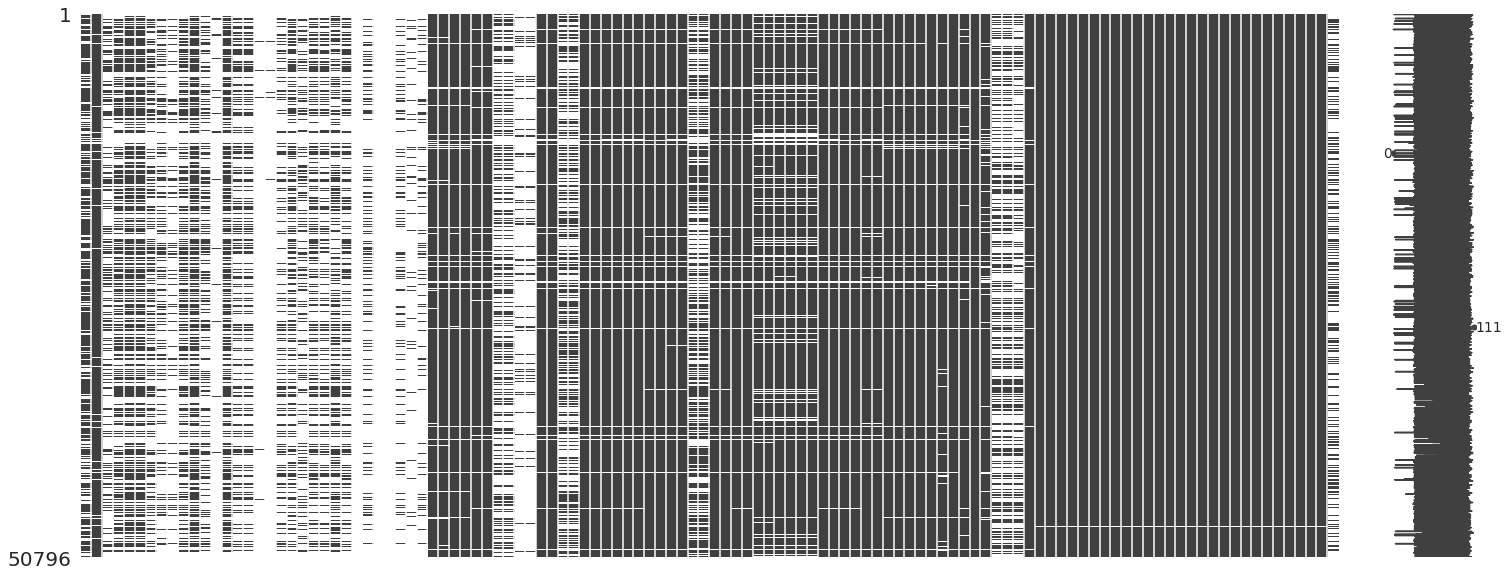

In [48]:
import numpy as np
import pandas as pd
import matplotlib
import missingno as msno
%matplotlib inline

missingdata_df = df.columns[df.isnull().any()].tolist()
msno.matrix(df[missingdata_df])

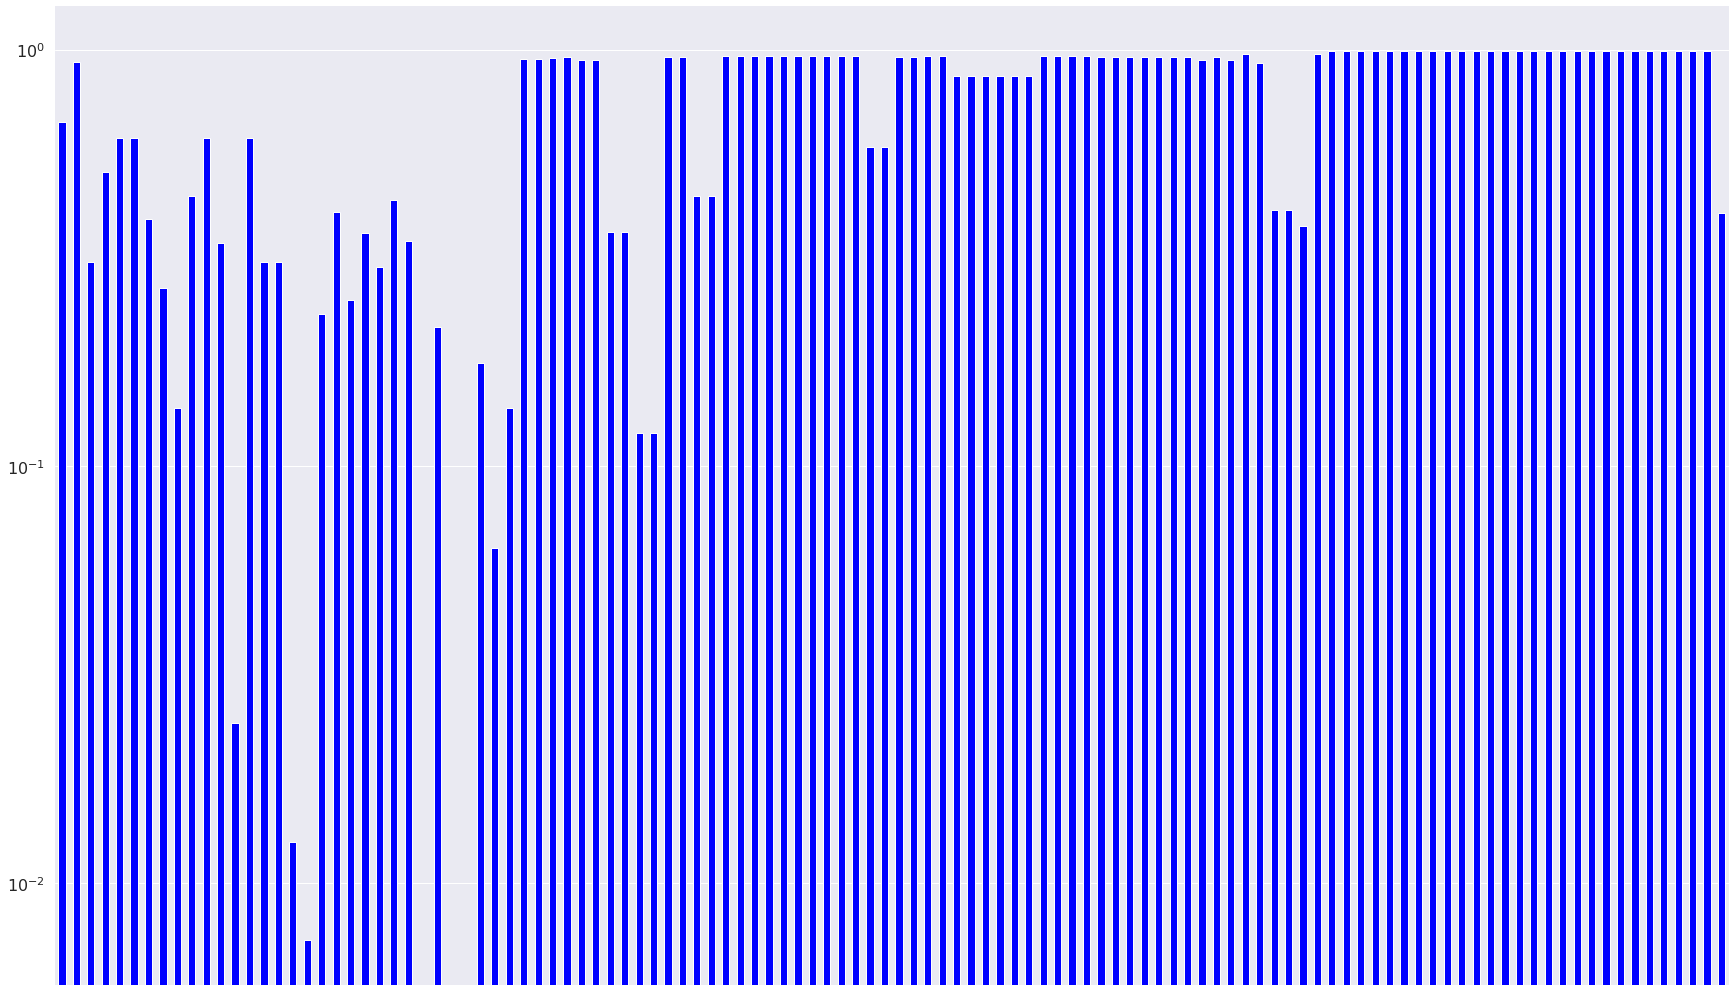

In [49]:
msno.bar(df[missingdata_df], color="blue", log=True, figsize=(30,18))

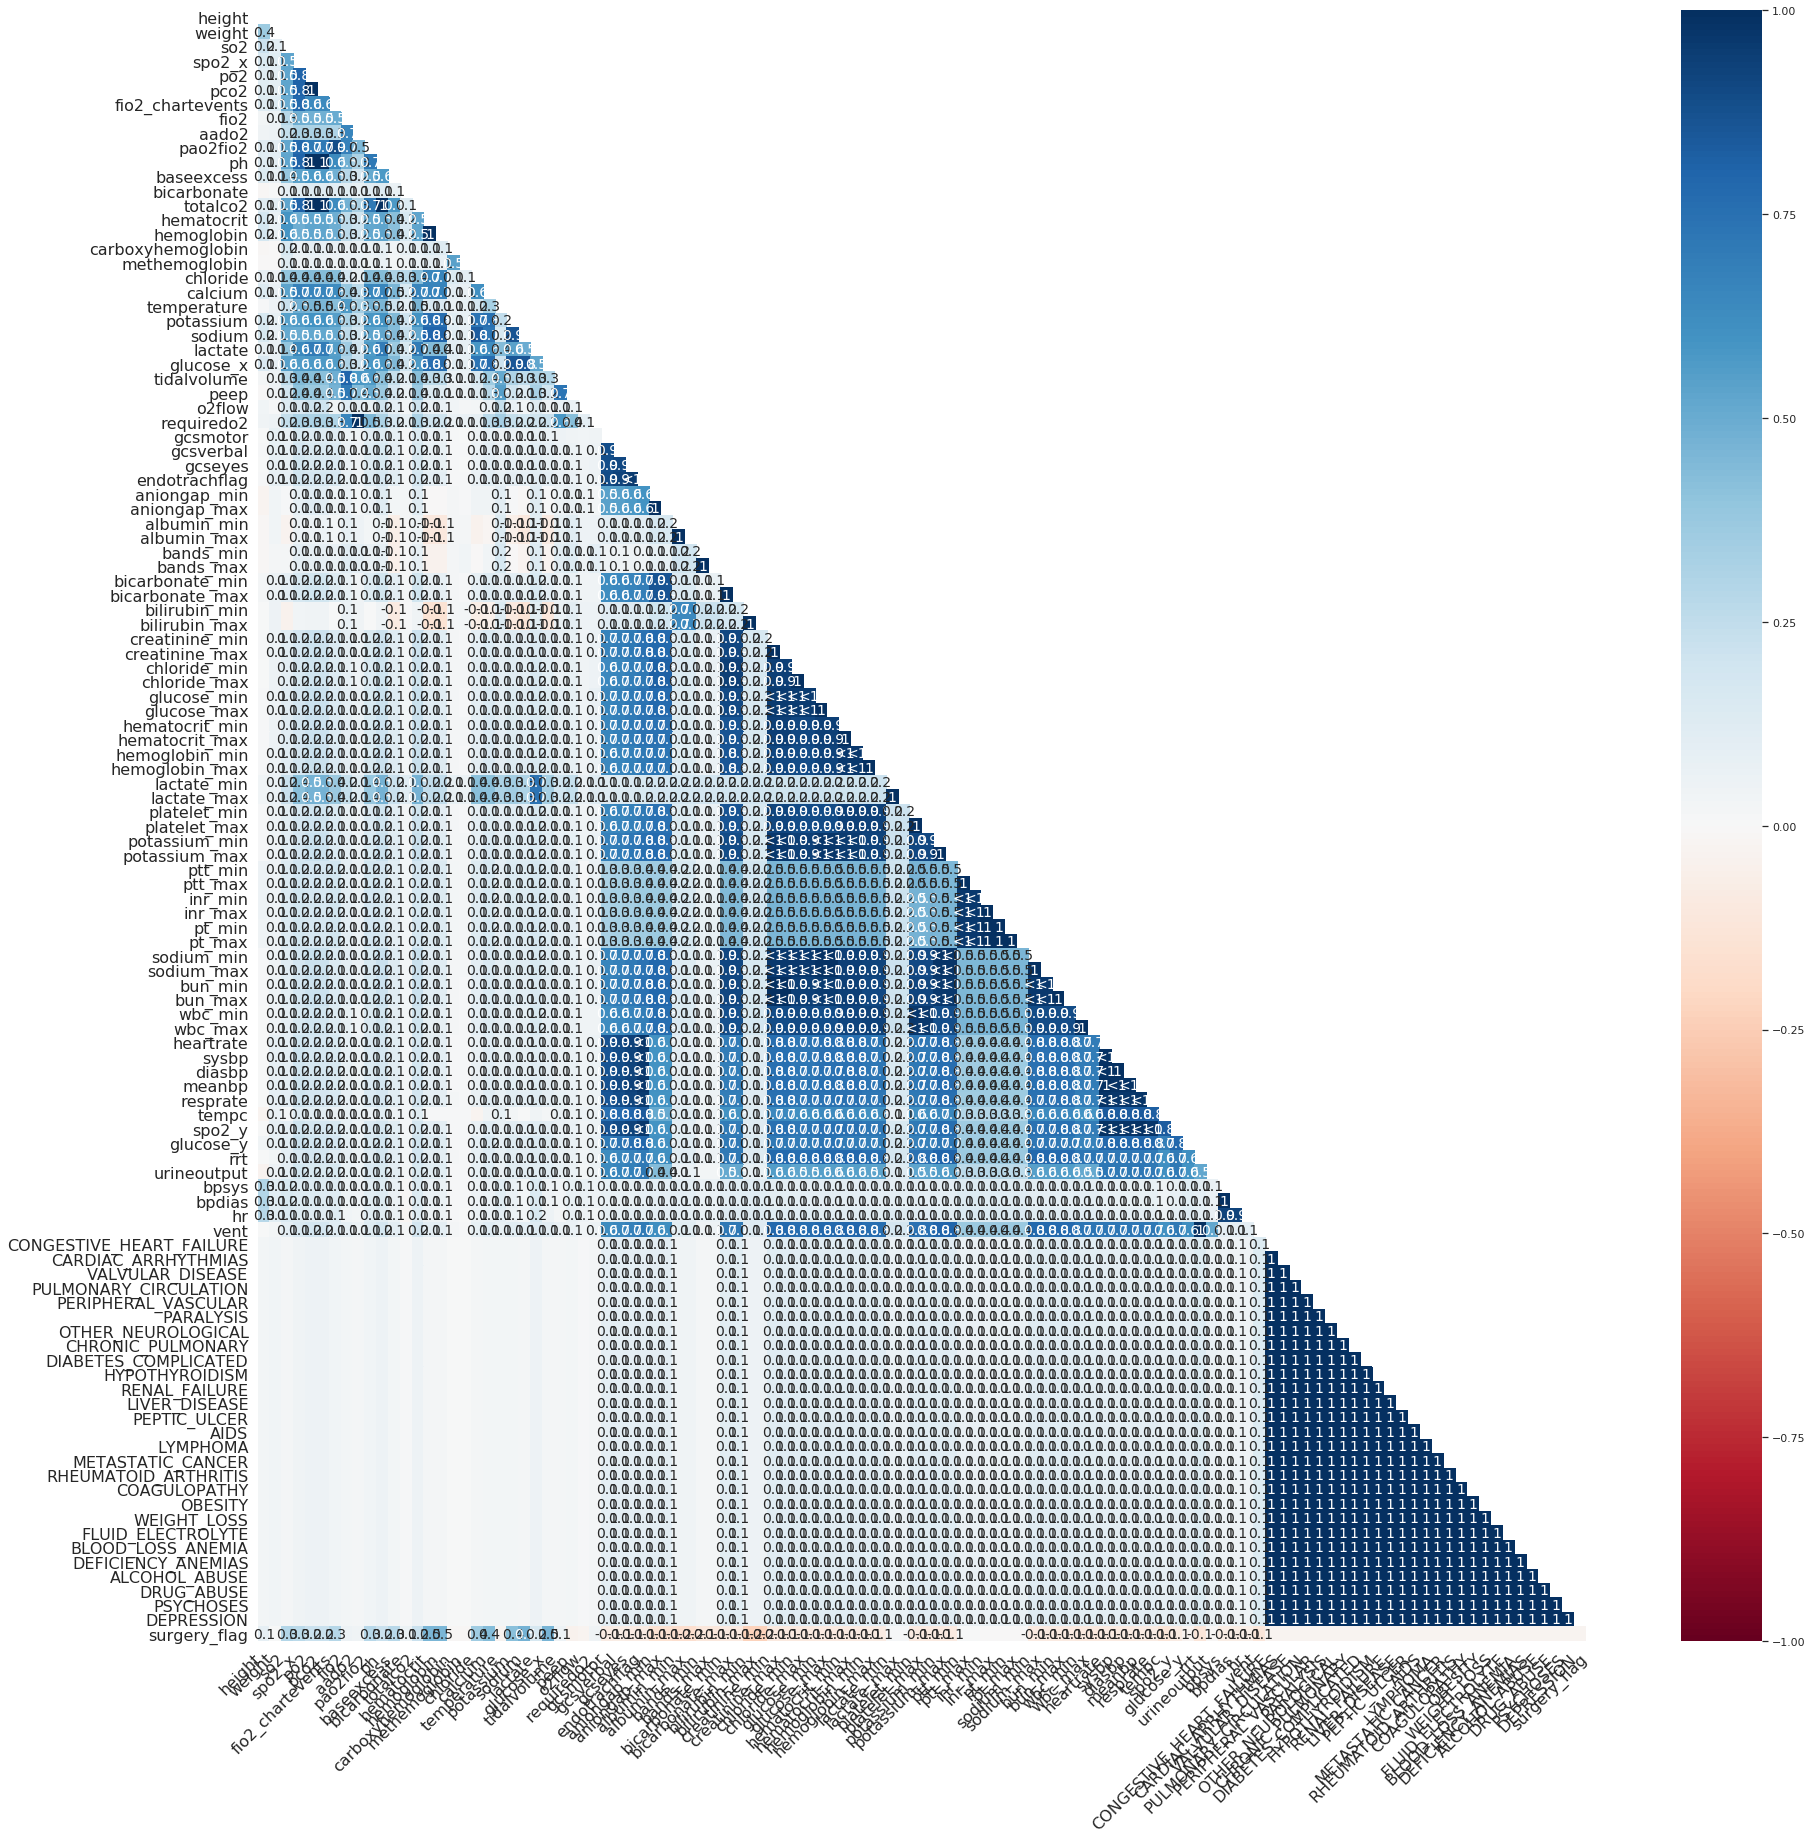

In [50]:
msno.heatmap(df[missingdata_df], figsize=(30,30))

In [51]:
# replace all nan values with 0 in the dataframe
df.replace(np.nan, 0, inplace=True)

In [52]:
# create a list from the gender column of the dataframe.
le = LabelEncoder()
le.fit(df['admission_type'].astype(str))
df['admission_type'] = le.transform(df['admission_type'].astype(str))

In [53]:
le.fit(df['gender'].astype(str))
df['gender'] = le.transform(df['gender'].astype(str))

In [54]:
df

subject_id  hadm_id  admission_type  hptl_stay  gender  age  age_range  \
0               3   145834               1         11       1   76        8.0   
1               4   185777               1          7       0   48        5.0   
2               6   107064               0         16       0   66        7.0   
3               9   150750               1          5       1   41        4.0   
4              11   194540               1         25       0   50        5.0   
...           ...      ...             ...        ...     ...  ...        ...   
50791       99985   176670               1         16       1   54        6.0   
50792       99991   151118               0         12       1   47        5.0   
50793       99992   197084               1          3       0   66        7.0   
50794       99995   137810               0          3       0   89        9.0   
50795       99999   113369               0          5       0   63        7.0   

       mean_stay  height weight  ...  OBESITY  WEIGHT_LOSS  FLUID_ELECTROLYTE  \
0      10.070670  179.07   96.8  ...      0.0          1.0                0.0   
1      10.084559    0.00   53.6  ...      0.0          1.0                1.0   
2      10.716571    0.00      0  ...      0.0          0.0                1.0   
3       9.628913  182.88    104  ...      0.0          0.0                1.0   
4      10.084559    0.00      0  ...      0.0          0.0                0.0   
...          ...     ...    ...  ...      ...          ...                ...   
50791  10.156342    0.00      0  ...      0.0          0.0                0.0   
50792  10.203017    0.00  100.5  ...      0.0          0.0                1.0   
50793  10.716571    0.00   65.4  ...      0.0          0.0                0.0   
50794   8.951552  159.00     68  ...      0.0          0.0                0.0   
50795  10.716571  152.00   96.5  ...      0.0          0.0                0.0   

       BLOOD_LOSS_ANEMIA  DEFICIENCY_ANEMIAS  ALCOHOL_ABUSE  DRUG_ABUSE  \
0                    0.0                 0.0            0.0         0.0   
1                    0.0                 0.0            0.0         0.0   
2                    0.0                 0.0            0.0         0.0   
3                    0.0                 0.0            0.0         0.0   
4                    0.0                 0.0            0.0         0.0   
...                  ...                 ...            ...         ...   
50791                0.0                 0.0            0.0         0.0   
50792                0.0                 0.0            0.0         0.0   
50793                0.0                 0.0            0.0         0.0   
50794                0.0                 0.0            0.0         0.0   
50795                0.0                 0.0            0.0         0.0   

       PSYCHOSES  DEPRESSION  surgery_flag  
0            0.0         0.0           1.0  
1            0.0         0.0           0.0  
2            0.0         0.0           1.0  
3            0.0         0.0           0.0  
4            0.0         0.0           1.0  
...          ...         ...           ...  
50791        0.0         0.0           0.0  
50792        0.0         0.0           1.0  
50793        0.0         1.0           0.0  
50794        0.0         0.0           1.0  
50795        0.0         0.0           1.0  

[50796 rows x 127 columns]

In [55]:
# download dataframe
writer = pd.ExcelWriter('dataframe_priya.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

In [56]:
# input dataframe
X = df.iloc[:,7:126]
# output dataframe
y = df.iloc[:,-1]

In [57]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 10 best features

               Specs         Score
5                po2  1.482193e+06
25         glucose_x  1.245916e+06
23            sodium  1.089129e+06
10          pao2fio2  1.035814e+06
19          chloride  5.402159e+05
3                so2  3.049307e+05
15        hematocrit  2.703192e+05
27       tidalvolume  2.279062e+05
4             spo2_x  1.901526e+05
7   fio2_chartevents  1.689908e+05
16        hemoglobin  8.997582e+04
84       urineoutput  6.215410e+04
6               pco2  4.900404e+04
72           bun_max  3.654460e+04
22         potassium  3.360749e+04
14          totalco2  3.203023e+04
71           bun_min  2.789130e+04
59      platelet_min  2.500797e+04
1             height  2.401722e+04
87                hr  1.717586e+04


[0.01384021 0.01449863 0.01313139 0.01897876 0.01830873 0.01924863
 0.00719118 0.01220771 0.00606883 0.00289778 0.00593055 0.00976138
 0.00513432 0.00136091 0.01056351 0.04464352 0.02124811 0.00145055
 0.00113357 0.0215766  0.02218959 0.01517507 0.01413574 0.04163113
 0.00472257 0.01360209 0.         0.00506476 0.         0.
 0.00423873 0.00235669 0.00296127 0.01325139 0.00994267 0.0094336
 0.0074038  0.00912861 0.01134826 0.0103675  0.00941797 0.00369007
 0.00364417 0.00993368 0.00917645 0.00732657 0.00736405 0.00801397
 0.00795399 0.00854249 0.00956531 0.00969027 0.00867322 0.0117122
 0.00951093 0.01073583 0.00951248 0.00867825 0.00847389 0.00915688
 0.00863112 0.00938048 0.00960877 0.00765264 0.00816144 0.00737719
 0.00709298 0.00772313 0.00730718 0.01030862 0.00959953 0.00915523
 0.00942477 0.00853611 0.00852388 0.00941271 0.01030011 0.01006837
 0.00975805 0.01027266 0.01142543 0.01065887 0.00948469 0.0018011
 0.008539   0.00871664 0.00732514 0.00774557 0.02104997 0.00865528
 0.006

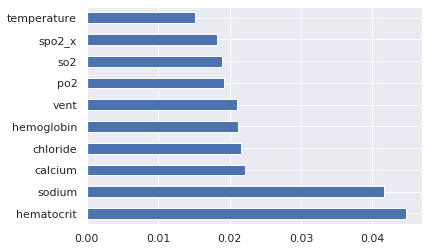

In [58]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

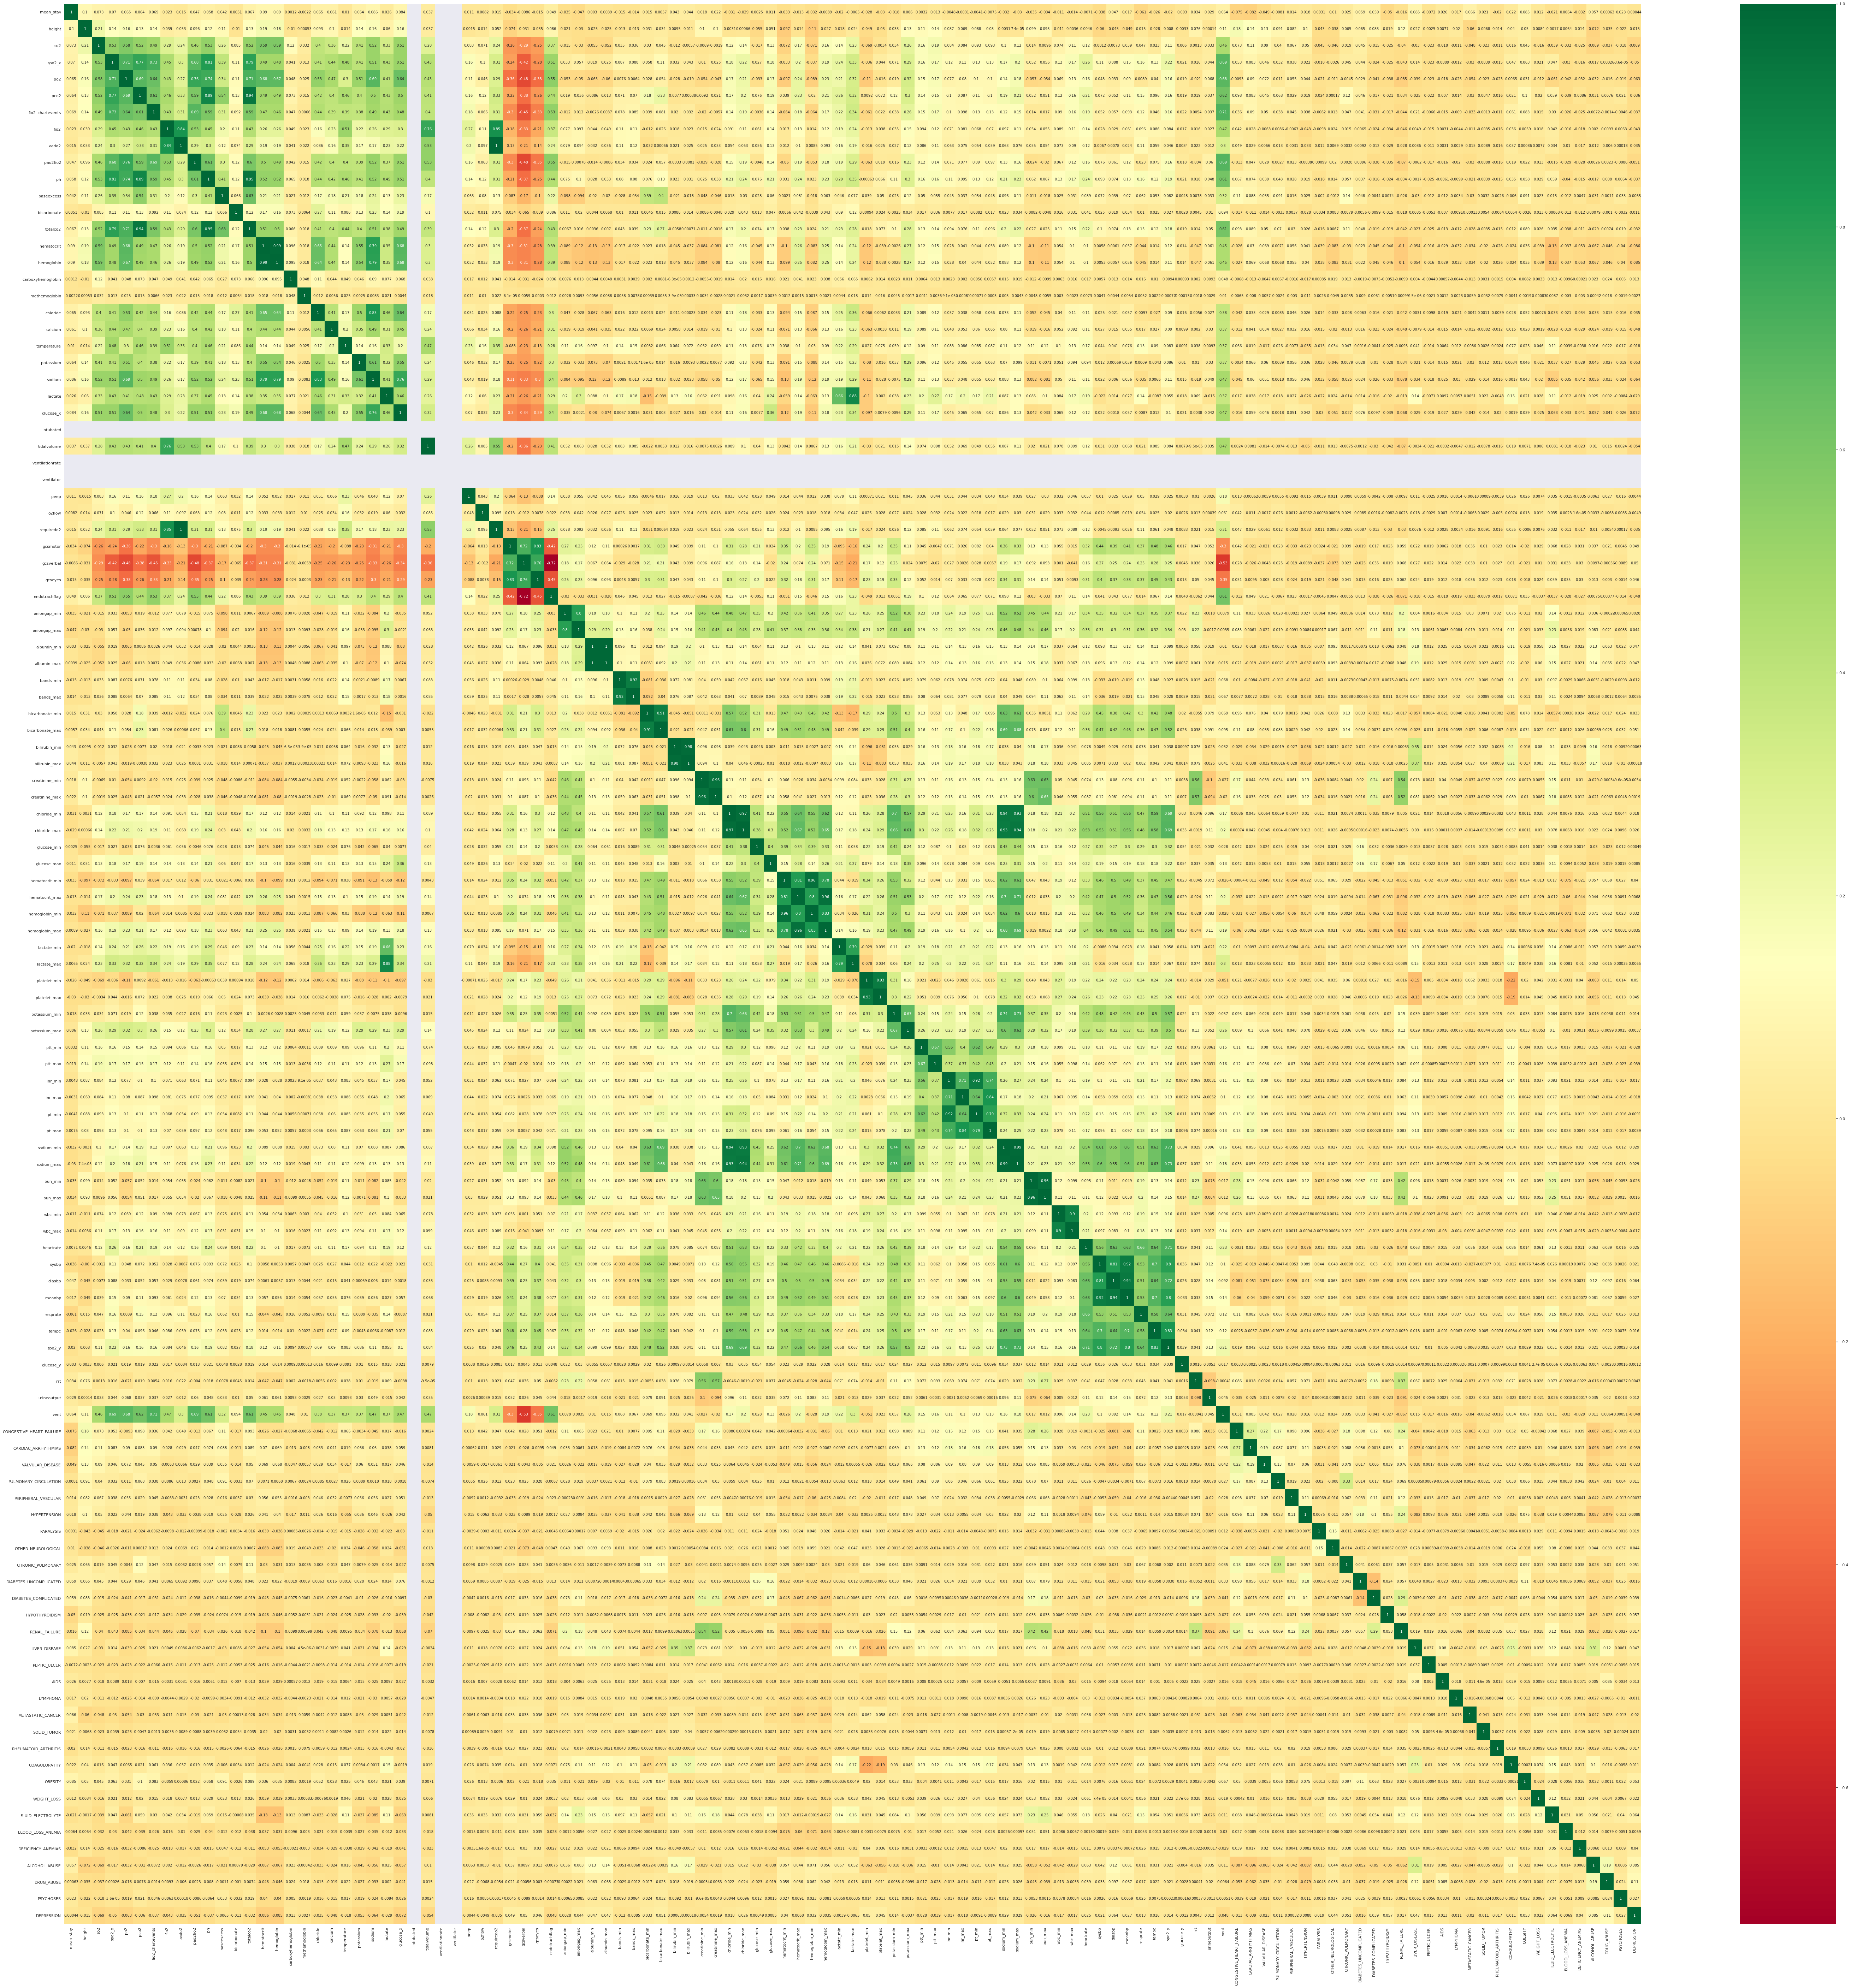

In [59]:
#get correlations of each features in dataset
corrmat = X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(100,100))
#plot heat map
g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [60]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pc = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.92751775, 0.04450706, 0.01235891, 0.00407375])

In [61]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [62]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

In [63]:
X_reduced

array([[-1.33408744e+03,  1.08928383e+02],
       [ 3.13404510e+02,  6.25371184e+01],
       [ 1.02504798e+02,  1.05966499e+01],
       ...,
       [-2.68077600e+02, -2.06766013e+01],
       [-3.37507739e+02, -7.56020180e+00],
       [ 2.67206789e+03, -3.92590838e-01]])

In [64]:
#from sklearn.ensemble import RandomForestClassifier
#rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
#rnd_clf.fit(X, y)
#for name, score in zip(X["feature_names"], rnd_clf.feature_importances_):
#    print(name, score)

In [68]:
#training the algorithm

estimator_values=[20,40,60,80,100]

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=20, random_state=0)
classifier.fit(X, y)
y_pred = classifier.predict(X)
y_pred

array([1., 0., 1., ..., 0., 1., 1.])

In [69]:
# evaluating the algorithm 
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y,y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y,y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

Mean Absolute Error: 0.0036026458776281596
Mean Squared Error: 0.0036026458776281596
Root Mean Squared Error: 0.06002204493041002


In [ ]:
estimator_values=[20,40,60,80,100]

In [71]:
classifier = RandomForestClassifier(n_estimators=100, random_state=0)
classifier.fit(X, y)
y_pred = classifier.predict(X)
y_pred

array([1., 0., 1., ..., 0., 1., 1.])

In [72]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y,y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y,y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

Mean Absolute Error: 0.00017717930545712261
Mean Squared Error: 0.00017717930545712261
Root Mean Squared Error: 0.013310871701625052


In [82]:
n_estimators=[20,40,60,80,100]
rmse_values=[]
for estimator in n_estimators:
    classifier = RandomForestClassifier(n_estimators=estimator, random_state=43)
    classifier.fit(X, y)
    y_pred = classifier.predict(X)
    RMSE=np.sqrt(metrics.mean_squared_error(y, y_pred))
    rmse_values.append(RMSE)
rmse_values  

[0.05768044404037523,
 0.023478170837324695,
 0.015370070720163592,
 0.013310871701625052,
 0.013310871701625052]

Text(0, 0.5, 'RMSE')

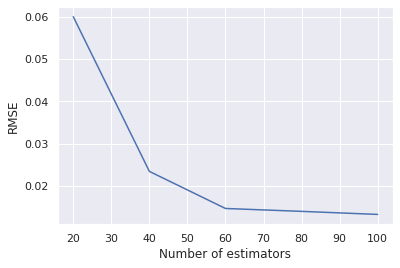

In [75]:
import matplotlib.pyplot as plt

plt.plot(n_estimators,rmse_values)
plt.xlabel("Number of estimators")
plt.ylabel("RMSE")

In [78]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y,y_pred))
print(classification_report(y,y_pred))
print(accuracy_score(y, y_pred))

[[30204     7]
 [    2 20583]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30211
         1.0       1.00      1.00      1.00     20585

    accuracy                           1.00     50796
   macro avg       1.00      1.00      1.00     50796
weighted avg       1.00      1.00      1.00     50796

0.9998228206945429


In [91]:
classifier = RandomForestClassifier(n_estimators=100, random_state=43)
classifier.fit(X, y)
y_pred = classifier.predict(X)
y_pred

array([1., 0., 1., ..., 0., 1., 1.])

In [93]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y,y_pred))
print(classification_report(y,y_pred))
print(accuracy_score(y, y_pred))

[[30204     7]
 [    2 20583]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30211
         1.0       1.00      1.00      1.00     20585

    accuracy                           1.00     50796
   macro avg       1.00      1.00      1.00     50796
weighted avg       1.00      1.00      1.00     50796

0.9998228206945429


In [95]:
classifier = RandomForestClassifier(n_estimators=80, random_state=43)
classifier.fit(X, y)
y_pred = classifier.predict(X)
y_pred

array([1., 0., 1., ..., 0., 1., 1.])

In [96]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y,y_pred))
print(classification_report(y,y_pred))
print(accuracy_score(y, y_pred))

[[30204     7]
 [    2 20583]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30211
         1.0       1.00      1.00      1.00     20585

    accuracy                           1.00     50796
   macro avg       1.00      1.00      1.00     50796
weighted avg       1.00      1.00      1.00     50796

0.9998228206945429


In [97]:
classifier = RandomForestClassifier(n_estimators=60, random_state=43)
classifier.fit(X, y)
y_pred = classifier.predict(X)
y_pred

array([1., 0., 1., ..., 0., 1., 1.])

In [98]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y,y_pred))
print(classification_report(y,y_pred))
print(accuracy_score(y, y_pred))

[[30204     7]
 [    5 20580]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30211
         1.0       1.00      1.00      1.00     20585

    accuracy                           1.00     50796
   macro avg       1.00      1.00      1.00     50796
weighted avg       1.00      1.00      1.00     50796

0.9997637609260571


In [99]:
classifier = RandomForestClassifier(n_estimators=40, random_state=43)
classifier.fit(X, y)
y_pred = classifier.predict(X)
y_pred

array([1., 0., 1., ..., 0., 1., 1.])

In [100]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y,y_pred))
print(classification_report(y,y_pred))
print(accuracy_score(y, y_pred))

[[30204     7]
 [   21 20564]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30211
         1.0       1.00      1.00      1.00     20585

    accuracy                           1.00     50796
   macro avg       1.00      1.00      1.00     50796
weighted avg       1.00      1.00      1.00     50796

0.9994487754941334


In [101]:
classifier = RandomForestClassifier(n_estimators=20, random_state=43)
classifier.fit(X, y)
y_pred = classifier.predict(X)
y_pred

array([1., 0., 1., ..., 0., 1., 1.])

In [102]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y,y_pred))
print(classification_report(y,y_pred))
print(accuracy_score(y, y_pred))

[[30196    15]
 [  154 20431]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     30211
         1.0       1.00      0.99      1.00     20585

    accuracy                           1.00     50796
   macro avg       1.00      1.00      1.00     50796
weighted avg       1.00      1.00      1.00     50796

0.9966729663753051


Text(0, 0.5, 'accuracy_score')

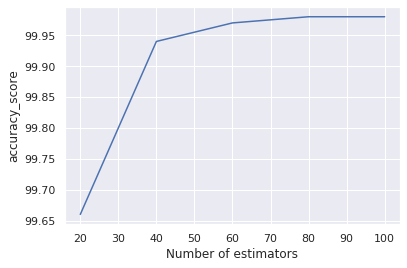

In [105]:
import matplotlib.pyplot as plt
n_estimators=[20,40,60,80,100]
accuracy_score=[99.66,99.94,99.97,99.98,99.98]

plt.plot(n_estimators,accuracy_score)
plt.xlabel("Number of estimators")
plt.ylabel("accuracy_score")

In [108]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from inspect import signature
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)

In [111]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [112]:
probs = rf.predict_proba(X_test)

In [113]:
malignant_probs = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, malignant_probs)
roc_auc = auc(fpr, tpr)

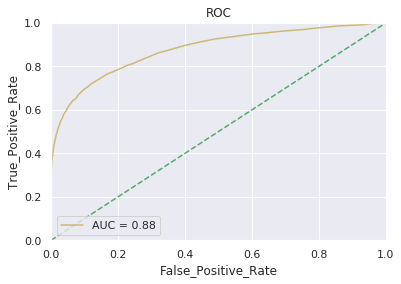

In [115]:
plt.title('ROC')
plt.plot(fpr, tpr, 'y', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower left')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True_Positive_Rate')
plt.xlabel('False_Positive_Rate')
plt.show()